<div style="text-align:center">
  
## Road Accident Data Analysis Report (BDDM)
    
</div>

## Table of Contents


###  Import Libraries

###  Data Extraction
1. [Modularity Function.](#task1)
2. [Merging and Filtering Dataframes.](#task2)


###  Data Cleaning and Premilinary Processing
1. [Validating Data Types in the DataFrame](#task3)
2. [Addressing Duplicate Entries](#task4)
3. [Addressing Null Values](#task5)
4. [Correcting Anomalies in the Numerical Features](#task6)


###  Answers and Additional Insights
1. [Are there significant hours of the day, and days of the week, on which accidents occur?](#task11a)
    - [Month](#task11b)
    - [Seasons](#task11c)
    - [Quarter](#task11d)
    - [Days of the Week](#task11e)
    - [Week](#task11f)
    - [Hour](#task11g)
    - [Session of Day](#task11h)

2. [For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur?](#task12a)
3. [For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?](#task13a)
4. [How do driver characteristics (e.g., age, gender, experience) influence accident severity?](#task14a)
5. [What is the impact of vehicle characteristics (e.g., type, age, size) on accident likelihood and severity?](#task15a)
6. [Studying the Impact of Select Features on Accident Severity Using the Apriori Algorithm](#task16a)
7. [Run clustering on this data, what do these clusters reveal about the distribution of accidents in our region?](#task17a)
8. [Outlier detection for unusual entries in our data](#task19a)
9. [Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?](#task18a)

---


# Import Libraries

In [ ]:
pip install geopandas

In [ ]:
!pip install plotnine

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Date and time handling
import datetime
import time

# Database handling
import sqlite3

# Machine learning - preprocessing and feature selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder

# Machine learning - classification models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest

# Model evaluation and metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import silhouette_score

# Association rule mining
from mlxtend.frequent_patterns import apriori, association_rules

# Clustering and dimensionality reduction
from sklearn.cluster import KMeans
import folium
import geopandas as gpd

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Libraries imported.

## Data Extraction

### 1. Modularity Function. <a id="task1"></a>

A function might be handy in modularizing the operation of fetching dataframes from our SQL repository. The function below returns dataframes once the name of the database is passed.

In [ ]:
def db_to_df(database):
    # Connecting to the SQLite database
    with sqlite3.connect(database) as con:
        # Getting the table names from the database
        table_names = con.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

        # Initializing a dictionary to store the DataFrames
        dataframes = {}

        # Loop through each table and create DataFrames
        for table_name in table_names:
            df_name = f"{table_name[0]}_df"
            dataframes[df_name] = pd.read_sql_query(f"SELECT * FROM {table_name[0]}", con)

    return dataframes

Applying the function

In [ ]:
database = 'accident_data_v1.0.0_20231.db'
dataframe = db_to_df(database)
list(dataframe.keys())

['accident_df', 'casualty_df', 'vehicle_df', 'lsoa_df']

Going a step further to ensure all data subsets are allocated to variables.

In [ ]:
accident_df = dataframe['accident_df']
vehicle_df = dataframe['vehicle_df']
casualty_df = dataframe['casualty_df']
lsoa_df = dataframe['lsoa_df']

In [ ]:
accident_df.shape

(461352, 36)

In [ ]:
vehicle_df.shape

(849091, 28)

In [ ]:
casualty_df.shape

(600332, 19)

In [ ]:
lsoa_df.shape

(34378, 7)

### 2. Merging and Filtering Dataframes. <a id="task2"></a>

Merging the dataframes on the primary key.
- primary key = accident_index

In [ ]:
# Inner join accident df to vehicle df
df = accident_df.merge(vehicle_df, on='accident_index', how='inner')

df = df.merge(casualty_df, on='accident_index', how='inner')

In [ ]:
df.shape

(1158304, 81)

Since our focus is the year 2020 exclusively, let's filter out for entries for that year only

In [ ]:
df = df[df['accident_year'] == 2020]

df.shape # checking the number of rows and columns for our new subsetted dataframe

(220435, 81)

## Data Cleaning and Premilinary Processing

### 1. Validating Data Types in the DataFrame <a id="task3"></a>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220435 entries, 937869 to 1158303
Data columns (total 81 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               220435 non-null  object 
 1   accident_year_x                              220435 non-null  int64  
 2   accident_reference_x                         220435 non-null  object 
 3   location_easting_osgr                        220401 non-null  float64
 4   location_northing_osgr                       220401 non-null  float64
 5   longitude                                    220401 non-null  float64
 6   latitude                                     220401 non-null  float64
 7   police_force                                 220435 non-null  int64  
 8   accident_severity                            220435 non-null  int64  
 9   number_of_vehicles                           220435 non-nu

###### Let's check the counts of the data types, and arrange them accordingly, looking out for anomalies in our data

In [ ]:
# Checking the count of data types in the DataFrame
df.dtypes.value_counts()

int64      67
object     10
float64     4
Name: count, dtype: int64

In [ ]:
# Filtering out for columns with data type 'integer'
integer_cols = df.select_dtypes(include='int').columns

integer_cols

Index(['accident_year_x', 'police_force', 'accident_severity',
       'number_of_vehicles', 'number_of_casualties', 'day_of_week',
       'local_authority_district', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'vehicle_index', 'accident_year_y',
       'vehicle_reference_x', 'vehicle_type', 'towing_and_articulation',
       'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leavi

Putting wrongly classified integer type features into 'cat_cols'

In [ ]:
# Identifying falsely classified int dtype features and assigning them to the 'categorical_column' variable
cat_cols = [
    'police_force', 'accident_severity', 'day_of_week', 'local_authority_district',
    'first_road_class', 'road_type', 'junction_detail', 'junction_control',
    'second_road_class', 'pedestrian_crossing_human_control',
    'pedestrian_crossing_physical_facilities', 'light_conditions',
    'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site',
    'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag', 'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre',
    'vehicle_direction_from', 'vehicle_direction_to', 'vehicle_location_restricted_lane',
    'junction_location', 'skidding_and_overturning', 'hit_object_in_carriageway',
    'vehicle_leaving_carriageway', 'hit_object_off_carriageway', 'first_point_of_impact',
    'vehicle_left_hand_drive', 'journey_purpose_of_driver', 'sex_of_driver',
    'age_band_of_driver', 'propulsion_code', 'age_band_of_casualty',
    'casualty_severity', 'pedestrian_location', 'pedestrian_movement', 'car_passenger',
    'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'casualty_type',
    'casualty_home_area_type', 'first_road_number', 'second_road_number', 'vehicle_index', 'driver_imd_decile',
    'driver_home_area_type', 'casualty_index', 'casualty_reference', 'casualty_class',
    'sex_of_casualty', 'casualty_imd_decile'
]

In [ ]:
#Correcting  wrongly classified features as type 'object'
df[cat_cols] = df[cat_cols].astype('object')

In [ ]:
#Checking to confirm changes
remaining_integer_columns = df.select_dtypes(include='int').columns

remaining_integer_columns

Index(['accident_year_x', 'number_of_vehicles', 'number_of_casualties',
       'speed_limit', 'accident_year_y', 'vehicle_reference_x',
       'age_of_driver', 'engine_capacity_cc', 'age_of_vehicle',
       'accident_year', 'vehicle_reference_y', 'age_of_casualty'],
      dtype='object')

In [ ]:
# Final summary of DataFrame data types
final_dtype_counts = df.dtypes.value_counts()

final_dtype_counts

object     65
int64      12
float64     4
Name: count, dtype: int64

### 2. Addressing Duplicate Entries <a id="task4"></a>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220435 entries, 937869 to 1158303
Data columns (total 81 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               220435 non-null  object 
 1   accident_year_x                              220435 non-null  int64  
 2   accident_reference_x                         220435 non-null  object 
 3   location_easting_osgr                        220401 non-null  float64
 4   location_northing_osgr                       220401 non-null  float64
 5   longitude                                    220401 non-null  float64
 6   latitude                                     220401 non-null  float64
 7   police_force                                 220435 non-null  object 
 8   accident_severity                            220435 non-null  object 
 9   number_of_vehicles                           220435 non-nu

We can see that duplicate features end with '_x' and '_y', we can write a program that filters these out to be removed.

In [ ]:
dup_cols = [col for col in df.columns if col.endswith(('_x', '_y'))]

dup_cols

['accident_year_x',
 'accident_reference_x',
 'accident_year_y',
 'accident_reference_y',
 'vehicle_reference_x',
 'vehicle_reference_y']

In [ ]:
# Removing the duplicate features as identified
df.drop(dup_cols, axis=1, inplace=True)

In [ ]:
df.shape

(220435, 75)

### 3. Addressing Null Values <a id="task5"></a>

Let's get the top features with Null values

In [ ]:
(df.isna().sum().sort_values(ascending=False)/df.shape[0]*100).head(10)

location_easting_osgr     0.015424
location_northing_osgr    0.015424
longitude                 0.015424
latitude                  0.015424
generic_make_model        0.000000
age_of_vehicle            0.000000
propulsion_code           0.000000
engine_capacity_cc        0.000000
age_band_of_driver        0.000000
age_of_driver             0.000000
dtype: float64

From the above, columns 'location_northing_osgr', 'longitude', 'latitude' and 'location_easting_osgr' have less than 1 percent of values that are empty. Let's check how similar these features are first.

In [ ]:
# checking column's correlation with 'longitude'
(df['location_easting_osgr'].corr(df['longitude']))

0.9994763675756485

In [ ]:
# checking column's correlation with 'latitude'
(df['location_northing_osgr'].corr(df['latitude']))

0.9999681660215938

Correlations is almost at 100%, so we'll drop 'location_northing_osgr' and 'location_easting_osgr'.

In [ ]:
df = df.drop(['location_easting_osgr', 'location_northing_osgr'], axis=1)

Now let's fill the NA values in the 'Longitude' and 'Latitude'

In [ ]:
df['longitude'] = df['longitude'].fillna(method='ffill')
df['latitude'] = df['latitude'].fillna(method='ffill')

In [ ]:
(df.isna().sum().sort_values(ascending=False)/df.shape[0]*100).head()

casualty_imd_decile    0.0
accident_year          0.0
accident_reference     0.0
casualty_reference     0.0
casualty_class         0.0
dtype: float64

Perfect!

### 4. Correcting Anomalies in the Numerical Features <a id="task6"></a>

Outliers

In [ ]:
num_cols = df[
    ['number_of_vehicles', 'number_of_casualties', 'speed_limit', 'age_of_driver',
     'age_of_vehicle', 'accident_year', 'age_of_casualty', 'engine_capacity_cc']
]

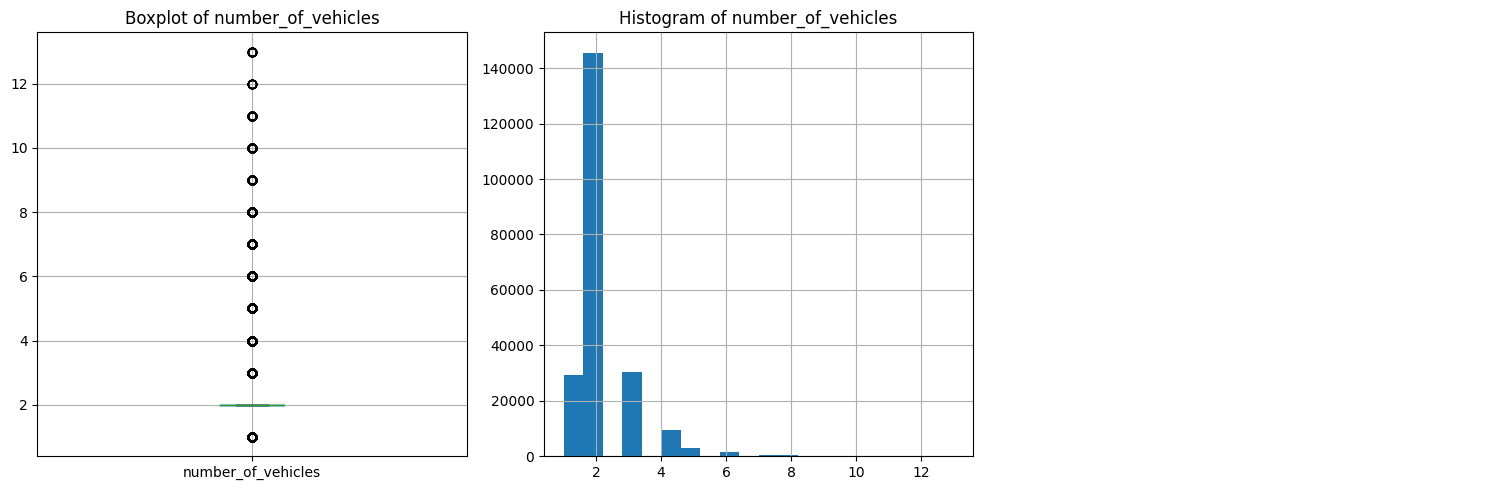

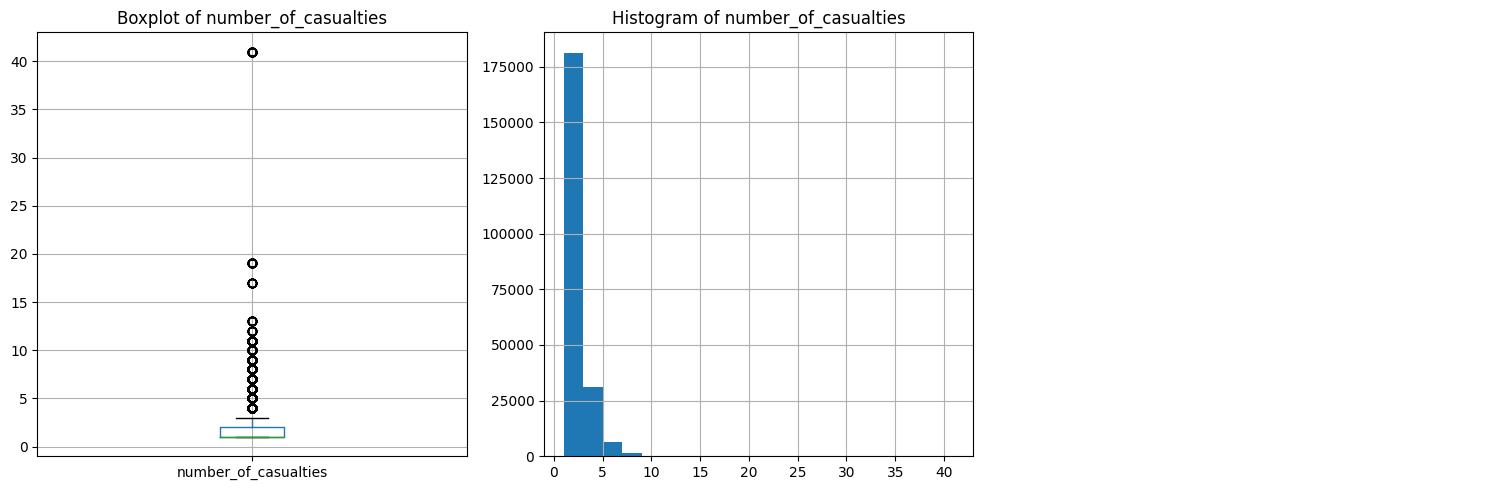

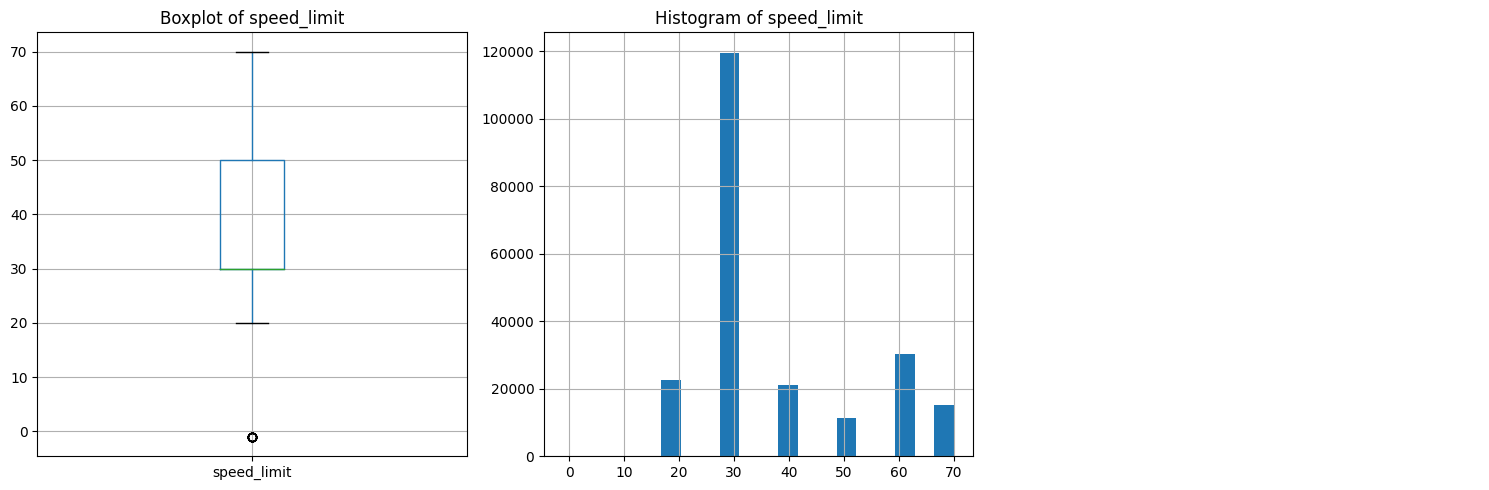

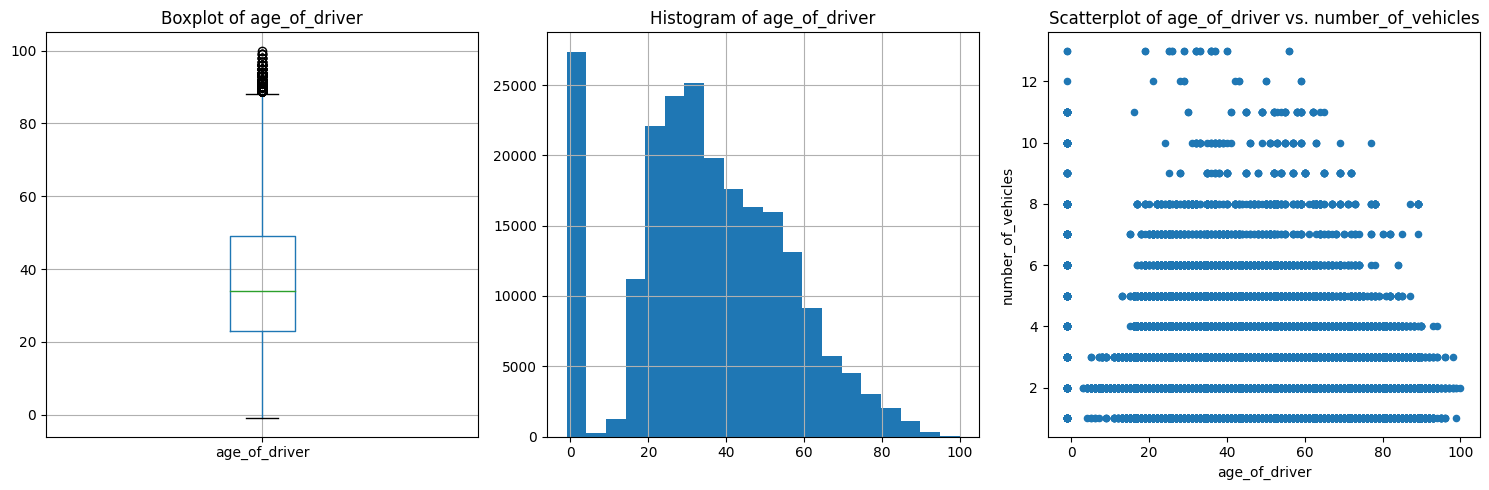

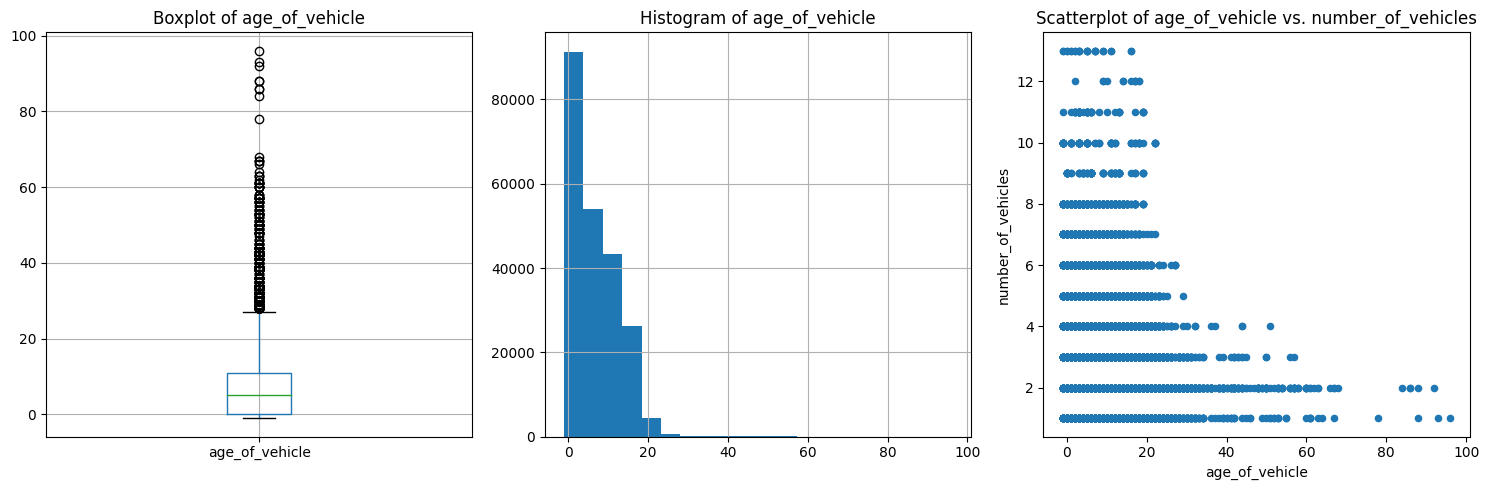

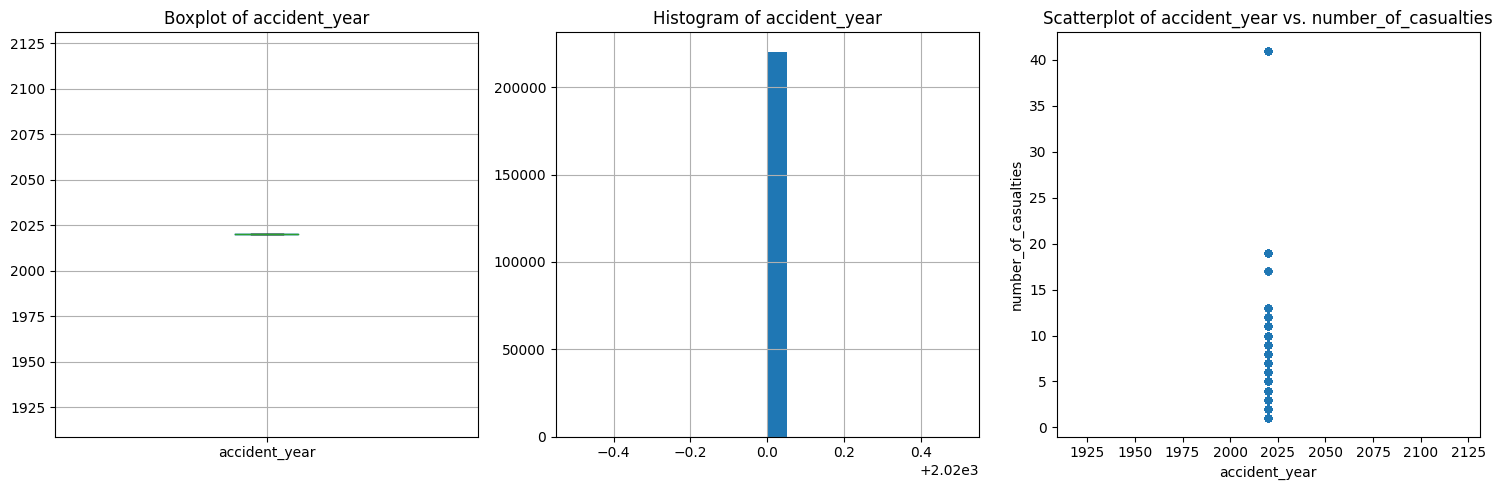

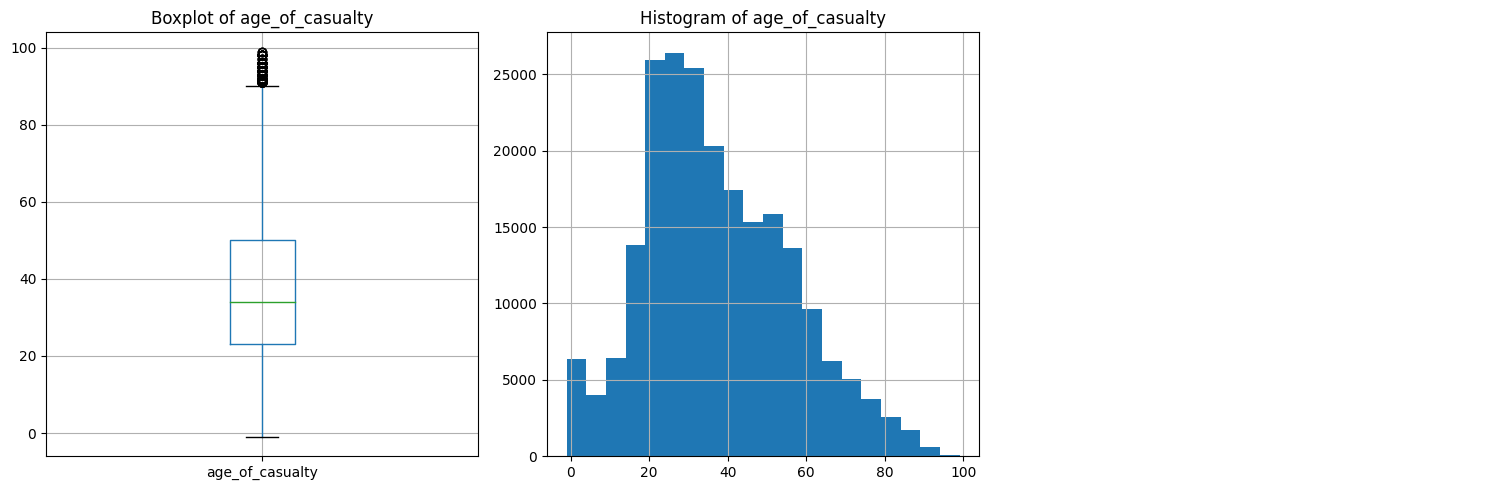

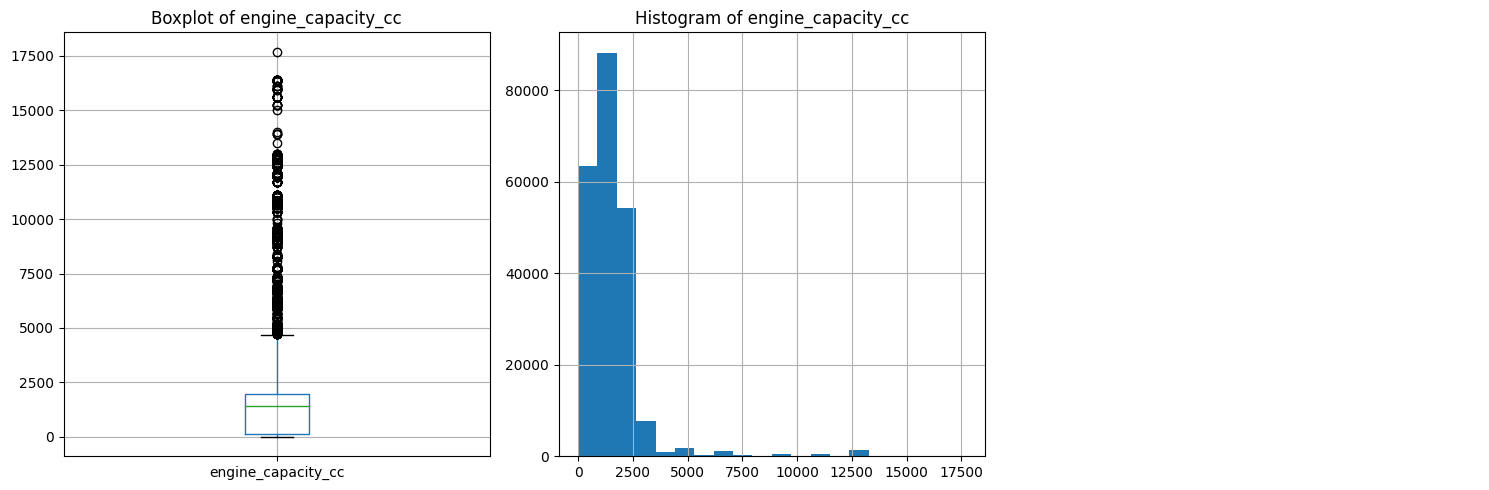

In [ ]:
# Looping through each numerical column and creating plots
for column in num_cols.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Boxplot
    num_cols.boxplot(column=column, ax=axes[0])
    axes[0].set_title(f'Boxplot of {column}')

    # Histogram
    num_cols[column].hist(ax=axes[1], bins=20)
    axes[1].set_title(f'Histogram of {column}')

    # Scatterplot (for selected features)
    if column in ['age_of_driver', 'age_of_vehicle']:
        num_cols.plot.scatter(x=column, y='number_of_vehicles', ax=axes[2])
        axes[2].set_title(f'Scatterplot of {column} vs. number_of_vehicles')
    elif column == 'accident_year':
        num_cols.plot.scatter(x=column, y='number_of_casualties', ax=axes[2])
        axes[2].set_title(f'Scatterplot of {column} vs. number_of_casualties')
    else:
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
num_cols.describe() # Statistical summary of numerical features

number_of_vehicles  number_of_casualties    speed_limit  age_of_driver  \
count       220435.000000         220435.000000  220435.000000  220435.000000   
mean             2.191127              1.739583      37.864432      35.156604   
std              0.919870              1.330668      14.616660      20.428323   
min              1.000000              1.000000      -1.000000      -1.000000   
25%              2.000000              1.000000      30.000000      23.000000   
50%              2.000000              1.000000      30.000000      34.000000   
75%              2.000000              2.000000      50.000000      49.000000   
max             13.000000             41.000000      70.000000     100.000000   

       age_of_vehicle  accident_year  age_of_casualty  engine_capacity_cc  
count   220435.000000       220435.0    220435.000000       220435.000000  
mean         6.092485         2020.0        36.789725         1407.144061  
std          6.273140            0.0        18.623187         1542.884192  
min         -1.000000         2020.0        -1.000000           -1.000000  
25%          0.000000         2020.0        23.000000          125.000000  
50%          5.000000         2020.0        34.000000         1398.000000  
75%         11.000000         2020.0        50.000000         1968.000000  
max         96.000000         2020.0        99.000000        17696.000000

As observed by means of the statistical summary and the plots, We have possibly erroneously recorded data in the following columns ;

 - Age of Driver
 - Age of Vehicle
 - Age of Casualty
 - Speed Limit
 - Engine Capacity CC

 We shall handle these by first evaluating the proportion of incorrectly entered data and then applying appropriate imputation measures.

In [ ]:
# Defining the list of numerical features with errors
Problematic_cols = ['speed_limit', 'age_of_driver', 'age_of_vehicle', 'age_of_casualty', 'engine_capacity_cc']

# Looping through each numerical column and calculate the top 5 proportions
for column in Problematic_cols:
    # Calculating value counts and proportions for the current feature
    counts = df[column].value_counts()
    proportions = (counts / counts.sum())*100

    # Displaying the top 5 proportions for the current feature
    print(f"Top 5 proportions for '{column}':")
    print(proportions.head(20))
    print()

Top 5 proportions for 'speed_limit':
speed_limit
 30    54.259986
 60    13.786377
 20    10.286479
 40     9.602831
 70     6.936285
 50     5.121691
-1      0.006351
Name: count, dtype: float64

Top 5 proportions for 'age_of_driver':
age_of_driver
-1     12.417720
 30     3.151950
 29     2.263706
 28     2.226507
 25     2.226053
 27     2.152108
 32     2.120353
 26     2.112187
 40     2.059564
 23     2.059564
 31     2.057296
 33     2.057296
 24     2.034160
 34     2.024633
 22     1.996961
 35     1.995146
 20     1.995146
 21     1.949327
 19     1.936625
 36     1.852700
Name: count, dtype: float64

Top 5 proportions for 'age_of_vehicle':
age_of_vehicle
-1     22.891102
 4      5.720961
 1      5.692835
 5      5.368930
 3      5.289995
 2      5.176583
 6      4.944768
 7      4.436682
 13     4.286524
 8      4.069680
 12     3.928596
 10     3.899562
 9      3.808379
 11     3.700411
 14     3.510332
 15     2.954159
 0      2.395264
 16     2.328124
 17     1.835462
 18

The values above show us some astounding facts about our data. We are having high percentage values for '-1' in a number of features, clearly erroneous. For the sake of our pretreatment efforts, we will handle the wrong values by imputting other values into them and saving to a new file.

In [ ]:
# Saving basic data without error values corrected initially

print(df.shape)
df.to_csv('basic_df.csv', index=False)

(220435, 73)


#### Addressing the Incorrect Values

- Attempt 1

Trying to ascertain best correlated features to aid our filling process, If we get some columns that are decently correlated, we will go on to use the median or mode values to fill out our erroneous entries.

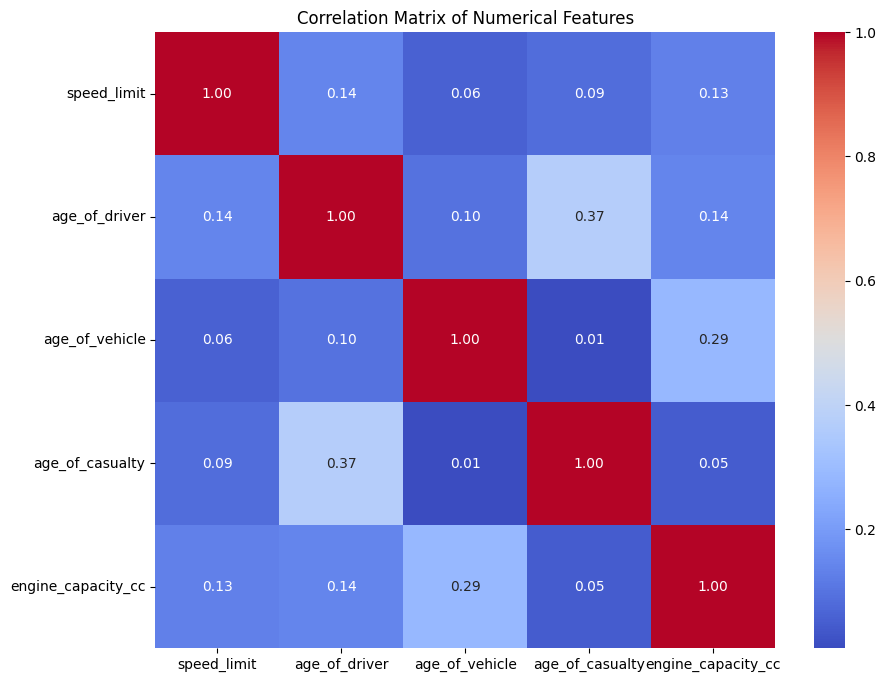

In [ ]:
# Calculating the correlation matrix
correlation_matrix = df[Problematic_cols].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

- Attempt 2

Since no substantial correlation exists between the previewed features, I'll be using a regular imputation approach by filling in with the median

In [ ]:
for col in Problematic_cols:
    # Calculating the median excluding -1 values
    median_val = df[df[col] != -1][col].median()

    # Replacing the -1 values with the median
    df.loc[df[col] == -1, col] = median_val

Correcting Wrong Age of Driver

In [ ]:
df['age_of_driver'].value_counts().sort_index().head(10)

age_of_driver
3       2
4      10
5      23
6      40
7      48
8      50
9      71
10    100
11    195
12    260
Name: count, dtype: int64

The youngest minimum driving age for movement device in the UK is 14 for electric bikes (https://www.gov.uk/electric-bike-ruleshttps://www.gov.uk/electric-bike-rules). In this case where we are having ages 13 and under for age of drivers, we can replace the values with the mode of the feature.

In [ ]:
# mode of the 'age_of_driver' column
mode = df['age_of_driver'].mode()[0]

# Replacing entries less than 14 years of age with the mode
df.loc[df['age_of_driver'] < 14, 'age_of_driver'] = mode

In [ ]:
summary = df[Problematic_cols].describe() # Summary statistic

summary

speed_limit  age_of_driver  age_of_vehicle  age_of_casualty  \
count  220435.000000  220435.000000   220435.000000    220435.000000   
mean       37.866401      40.137065        7.923773        37.528673   
std        14.613512      15.106535        4.967106        17.784567   
min        20.000000      14.000000        0.000000         0.000000   
25%        30.000000      29.000000        5.000000        24.000000   
50%        30.000000      38.000000        7.000000        34.000000   
75%        50.000000      49.000000       11.000000        50.000000   
max        70.000000     100.000000       96.000000        99.000000   

       engine_capacity_cc  
count       220435.000000  
mean          1778.105369  
std           1338.259657  
min              7.000000  
25%           1390.000000  
50%           1597.000000  
75%           1968.000000  
max          17696.000000

From the summary above, the error values have been addressed, time to go into insights!

In [ ]:
# Saving the corrected dataframe

df.to_csv('corrected_df.csv', index=False)

## Answers and Additional Insights

#### 1. Are there significant hours of the day, and days of the week, on which accidents occur? <a id="task11a"></a>

Since this question has to do with time, we can adopt a top-down, holistic approach in uncovering time-related trends about the frequency of accidents from our data. We shall be looking into the following time groups:

- Season of the year (Winter, Spring, Summer and Fall)
- Quarter of the year (1st through 4th)
- Month of the year
- Week of the month (1st to 4th)
- Day of the Week
- Session of the day (Early Morning, Morning Rush, Late Morning to Noon, Afternoon, Evening Rush, Night)
- Hour of the day

In [ ]:
df = pd.read_csv('corrected_df.csv') # reading in cleaned dataset

df.shape

(220435, 73)

Feature Engineering based on the Time categories

#### Month of the year <a id="task11b"></a>

In [ ]:
import calendar

In [ ]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Getting months from the date
df['month'] = df['date'].dt.month

In [ ]:
# function to get the name of the month
def get_month_name(month):
    return calendar.month_name[month]

# Applying the function to the 'month' column to get the month name
df['month_name'] = df['month'].apply(get_month_name)

In [ ]:
# Grouping the data by month name and count accidents per month
months_acc = df.groupby(['month_name'])['accident_index'].count()

# Displaying the frequency of accidents by month name
months_acc

month_name
April         7244
August       22367
December     19348
February     21265
January      23289
July         20094
June         16449
March        15715
May          13165
November     18104
October      20905
September    22490
Name: accident_index, dtype: int64

#### Seasons of the year<a id="task11c"></a>

In [ ]:
# Defining a function to map months to seasons
def seasons(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn (Fall)'

# Applying the function to the 'month' column to get the corresponding season
df['season'] = df['month'].apply(seasons)

In [ ]:
# Displaying the DataFrame with the 'season' column

df[['month', 'season']].head()

month  season
0      2  Winter
1      4  Spring
2      4  Spring
3      1  Winter
4      1  Winter

#### Quarter of the year<a id="task11d"></a>

In [ ]:
# function to map months to quarters
def quarter(month):
    if month in [1, 2, 3]:
        return '1st Quarter'
    elif month in [4, 5, 6]:
        return '2nd Quarter'
    elif month in [7, 8, 9]:
        return '3rd Quarter'
    else:
        return '4th Quarter'

# Applying the function to the 'month' column to get the corresponding quarter
df['quarter'] = df['month'].apply(quarter)

In [ ]:
# Displaying the DataFrame with the 'quarter' column

df[['month', 'quarter']].head()

month      quarter
0      2  1st Quarter
1      4  2nd Quarter
2      4  2nd Quarter
3      1  1st Quarter
4      1  1st Quarter

#### Days of the Week <a id="task11e"></a>

In [ ]:
df['day_of_week'].value_counts()

day_of_week
6    35938
5    33447
4    32692
3    31491
2    30677
7    30530
1    25660
Name: count, dtype: int64

In [ ]:
# Defining a function to map day of the week to its name
def dayname(day):
    if day == 1:
        return 'Monday'
    elif day == 2:
        return 'Tuesday'
    elif day == 3:
        return 'Wednesday'
    elif day == 4:
        return 'Thursday'
    elif day == 5:
        return 'Friday'
    elif day == 6:
        return 'Saturday'
    else:
        return 'Sunday'

# Apply the function to the 'weekday' column to get the corresponding day name
df['weekday'] = df['day_of_week'].apply(dayname)

In [ ]:
# Displaying  the DataFrame with the 'weekday' column

df[['day_of_week', 'weekday']].head()

day_of_week    weekday
0            3  Wednesday
1            2    Tuesday
2            2    Tuesday
3            4   Thursday
4            4   Thursday

#### Week of the month<a id="task11f"></a>

In [ ]:
# Defining a function to calculate the week of the month
def get_week_of_month(date):
    first_day = date.replace(day=1)
    adjusted_date = date if date.day >= 7 else first_day
    week = (adjusted_date.day - 1) // 7 + 1
    if week > 4:
        return 'Month End'
    else:
        return f'{week}{"th" if week > 3 else ["st", "nd", "rd"][week - 1]} Week'

# Applying the function to the 'date' column to get the week of the month
df['week_of_month'] = df['date'].apply(get_week_of_month)

In [ ]:
# Displaying the DataFrame with the 'week_of_month' column

df[['date', 'week_of_month']].head()

date week_of_month
0 2020-02-04      1st Week
1 2020-04-27      4th Week
2 2020-04-27      4th Week
3 2020-01-01      1st Week
4 2020-01-01      1st Week

#### Hour of the day<a id="task11g"></a>

In [ ]:
# Converting 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Checking the data type of 'time' column after conversion
df['time'].dtype

dtype('<M8[ns]')

In [ ]:
# Extracting the hour from the 'time' column
df['hour'] = df['time'].dt.hour

df['hour'].head()

0     9
1    13
2    13
3     1
4     1
Name: hour, dtype: int32

#### Session of the day<a id="task11h"></a>

In [ ]:
# Defining a function to categorize the session of the day based on the hour
def get_session(hour):
    if 5 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 9:
        return 'Morning Rush'
    elif 9 <= hour < 12:
        return 'Late Morning to Noon'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Evening Rush'
    else:
        return 'Night'

# Applying the function to the 'hour' column to get the session of the day
df['session_of_day'] = df['hour'].apply(get_session)

In [ ]:
# Displaying the DataFrame with the 'hour' and 'session_of_day' columns

df[['time', 'hour', 'session_of_day']].head()

time  hour        session_of_day
0 2024-04-25 09:00:00     9  Late Morning to Noon
1 2024-04-25 13:55:00    13             Afternoon
2 2024-04-25 13:55:00    13             Afternoon
3 2024-04-25 01:25:00     1                 Night
4 2024-04-25 01:50:00     1                 Night

Let's look at some insightful plots from these features

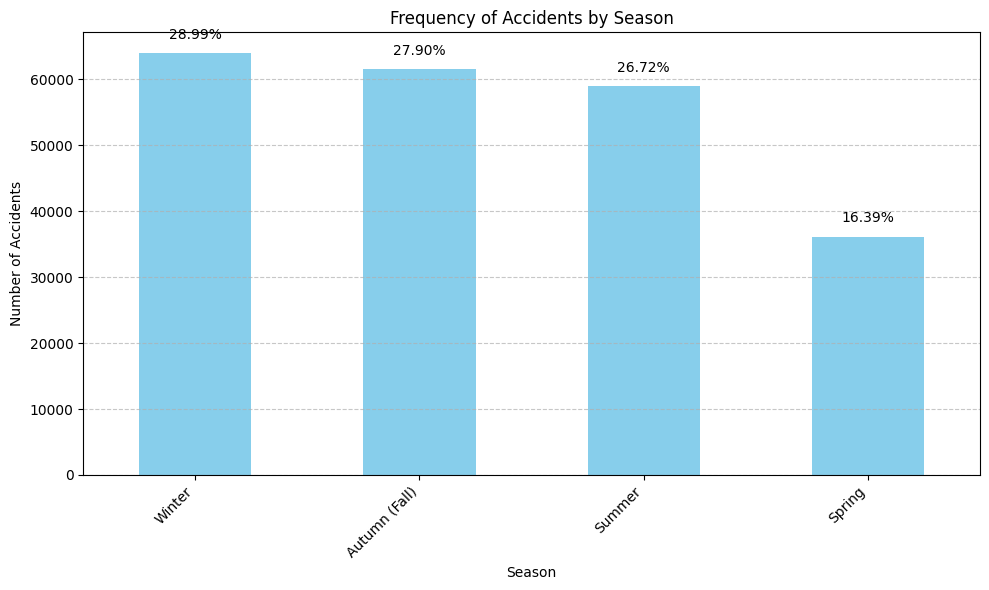

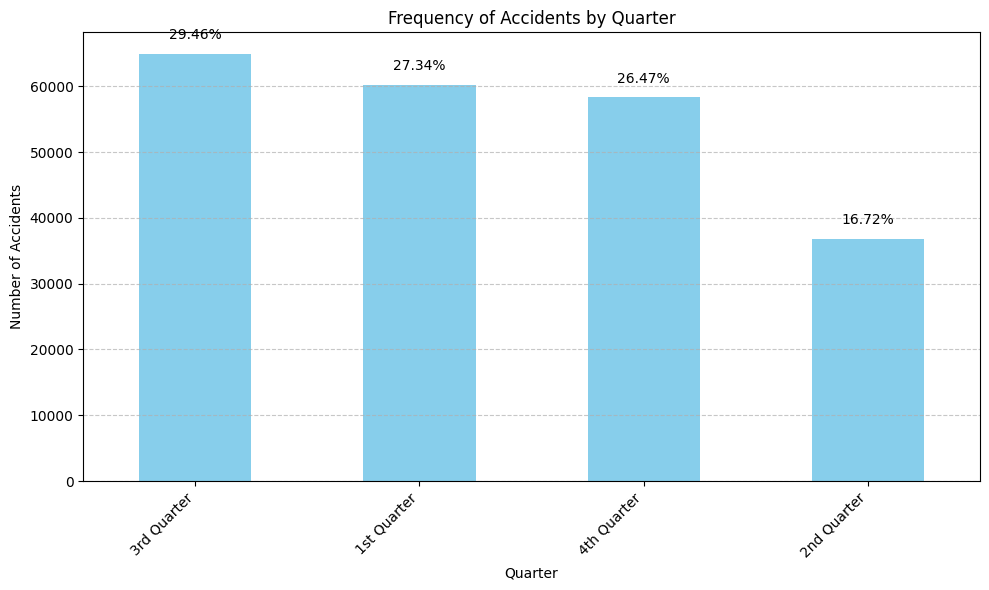

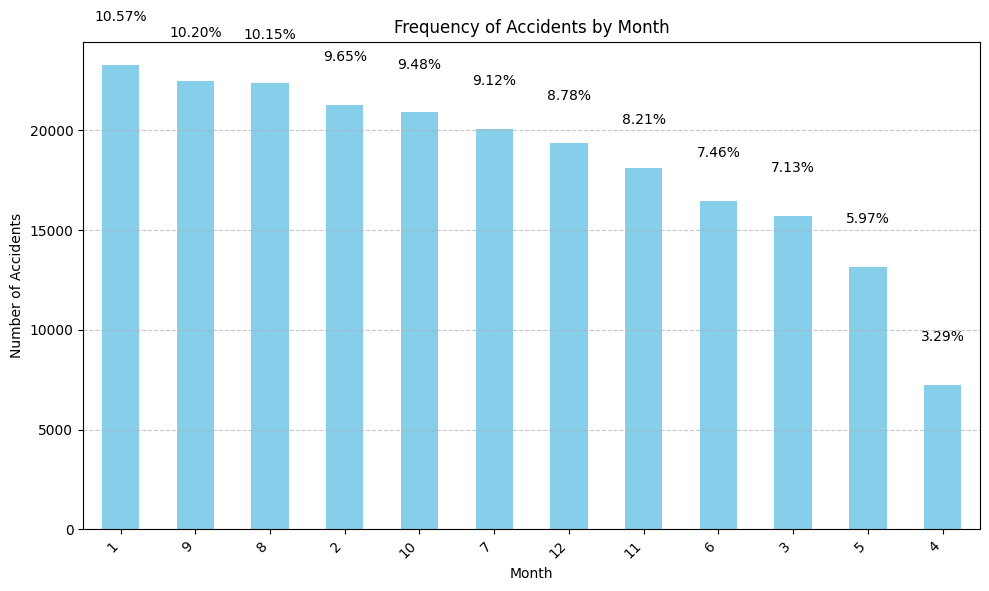

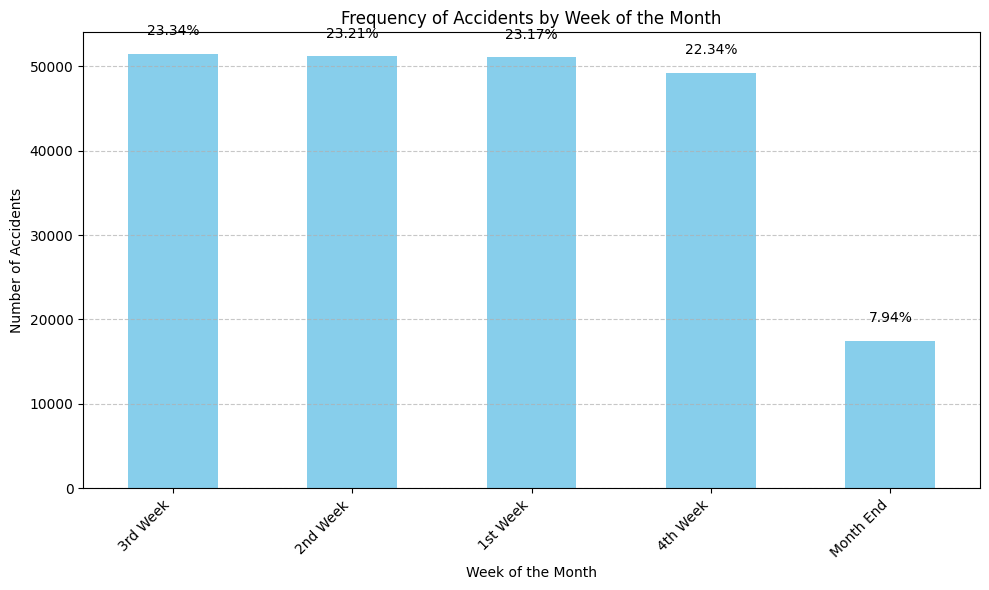

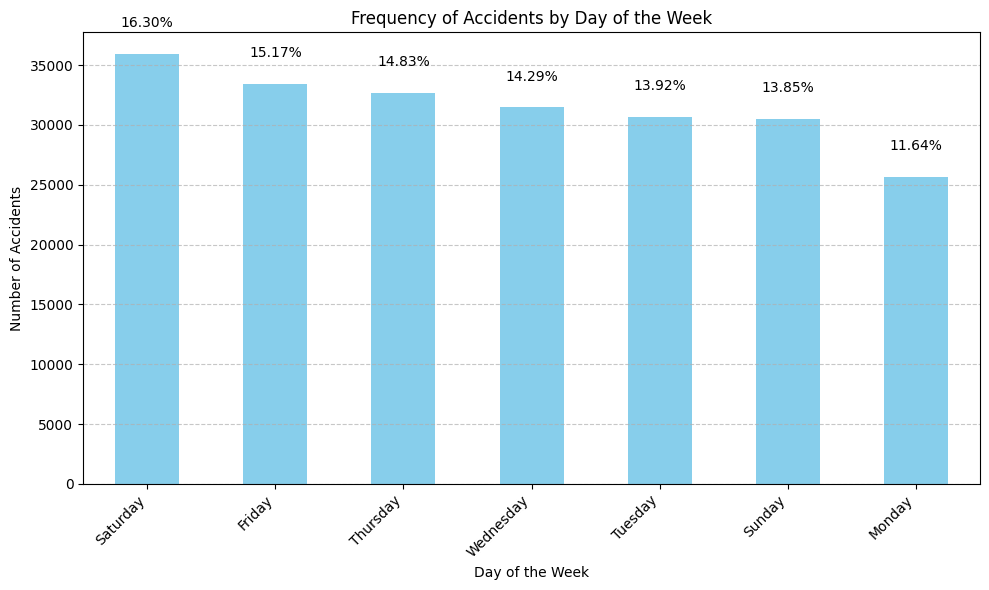

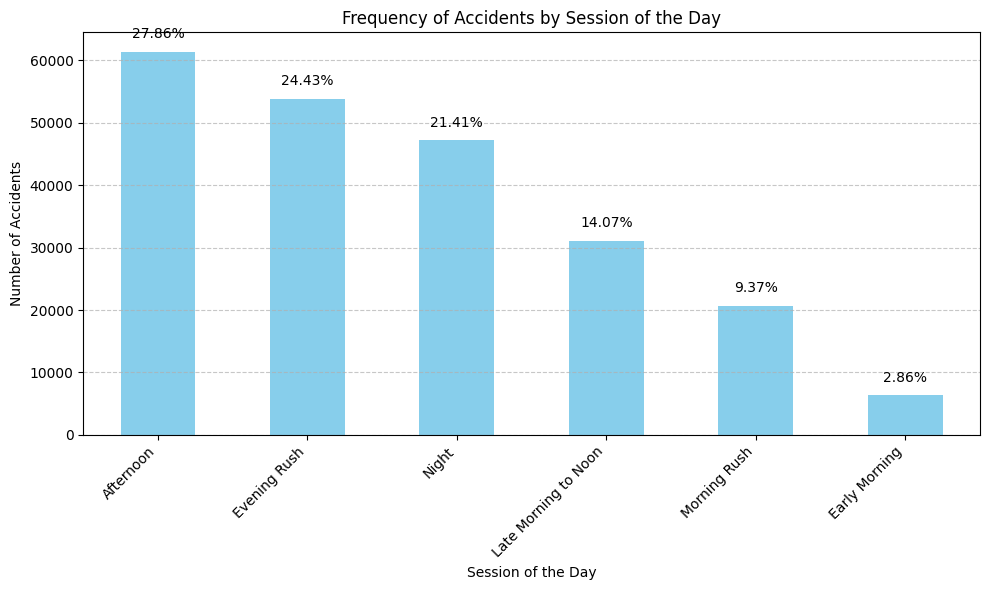

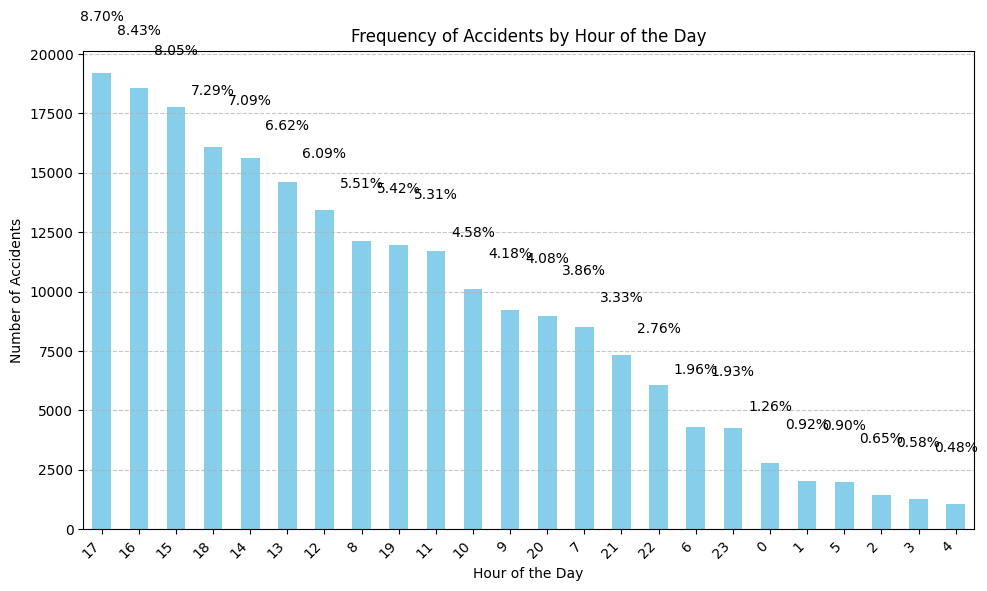

In [ ]:
# Defining a function to plot the frequency of accidents for a given category
def plot_accident_frequency(data, category_name):
    plt.figure(figsize=(10, 6))
    ax = data.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of Accidents by {category_name}')
    plt.xlabel(category_name)
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45, ha='right')  # Adjusting rotation and alignment of x-axis labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding percentage proportions to the top of each bar
    total = sum(data)
    for i, val in enumerate(data):
        plt.text(i, val + total * 0.01, f'{val/total*100:.2f}%', ha='center', fontsize=10)

    plt.tight_layout()  # Adjusting layout to prevent label overlap
    plt.show()

# Plotting the frequency of accidents by season
plot_accident_frequency(df['season'].value_counts(), 'Season')

# Plotting the frequency of accidents by quarter
plot_accident_frequency(df['quarter'].value_counts(), 'Quarter')

# Plotting the frequency of accidents by month
plot_accident_frequency(df['month'].value_counts(), 'Month')

# Plotting the frequency of accidents by week of the month
plot_accident_frequency(df['week_of_month'].value_counts(), 'Week of the Month')

# Plotting the frequency of accidents by day of the week
plot_accident_frequency(df['weekday'].value_counts(), 'Day of the Week')

# Plotting the frequency of accidents by session of the day
plot_accident_frequency(df['session_of_day'].value_counts(), 'Session of the Day')

# Plotting the frequency of accidents by hour of the day
plot_accident_frequency(df['hour'].value_counts(), 'Hour of the Day')


In [ ]:
# Let's identify the highest proportions for each feature using the function below

def calculate_highest_proportions(data):
    total = sum(data)
    proportions = data / total * 100
    highest_proportion = proportions.idxmax()
    second_highest_proportion = proportions.drop(highest_proportion).idxmax()
    return highest_proportion, max(proportions), second_highest_proportion, max(proportions.drop(highest_proportion))

# Features and their corresponding data
features_data = {
    'Season': df['season'].value_counts(),
    'Quarter': df['quarter'].value_counts(),
    'Month': df['month'].value_counts(),
    'Week of the Month': df['week_of_month'].value_counts(),
    'Day of the Week': df['weekday'].value_counts(),
    'Session of the Day': df['session_of_day'].value_counts(),
    'Hour of the Day': df['hour'].value_counts()
}

# DataFrame to store results
results_df = pd.DataFrame(columns=['Feature', 'Most Frequent Accident Window', 'Second Most Frequent Accident Window'])

# Iterate over each feature
for feature, data in features_data.items():
    most_frequent_period, highest_proportion, second_most_frequent_period, second_highest_proportion = calculate_highest_proportions(data)
    results_df.loc[len(results_df)] = [feature, f'{most_frequent_period} ({highest_proportion:.2f}%)', f'{second_most_frequent_period} ({second_highest_proportion:.2f}%)']


Let's obtain a summary of our High Probability Accident Periods.

In [ ]:
# Display the summary results

results_df

Feature Most Frequent Accident Window  \
0              Season               Winter (28.99%)   
1             Quarter          3rd Quarter (29.46%)   
2               Month                    1 (10.57%)   
3   Week of the Month             3rd Week (23.34%)   
4     Day of the Week             Saturday (16.30%)   
5  Session of the Day            Afternoon (27.86%)   
6     Hour of the Day                    17 (8.70%)   

  Second Most Frequent Accident Window  
0               Autumn (Fall) (27.90%)  
1                 1st Quarter (27.34%)  
2                           9 (10.20%)  
3                    2nd Week (23.21%)  
4                      Friday (15.17%)  
5                Evening Rush (24.43%)  
6                           16 (8.43%)

As we can see from our obtained results, it appears accidents are most prevalent during the winter season, accounting for 27.14% of all accidents, closely followed by the autumn season at 26.88%. The third quarter of the year stands out as the period with the highest accident frequency, representing 27.89% of all accidents, while the first quarter follows closely behind at 25.63%. January appears to be the month with the highest accident frequency at 10.31%, with September ranking second at 9.63%. Accidents are most likely to occur during the second week of the month (26.03%), followed by the third week (23.34%). Saturdays exhibit the highest accident frequency among weekdays, with 16.30% of accidents occurring on this day, while Fridays follow closely behind at 15.17%. During the day, the afternoon session accounts for the highest proportion of accidents at 27.86%, followed by the evening rush period at 24.43%. Finally, accidents peak at 17:00, representing 8.70% of all accidents, with 16:00 closely following at 8.43%.

#### 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? <a id="task12a"></a>

In [ ]:
df['vehicle_type'].value_counts()

vehicle_type
9     158331
1      17458
19     13647
3       8026
5       4393
21      3385
8       3355
11      2921
4       1863
90      1412
98      1372
20      1237
2       1194
17       547
97       521
10       355
22       198
16       109
23       100
18        11
Name: count, dtype: int64

Thankfully, through the dictionary provided, we can identify codes for Motorcycles within our vehicle type and map them appropriately.

In [ ]:
motorcycle_mapping = {
    2: 'Motorcycle 50cc and under',
    3: 'Motorcycle over 50cc and up to 125cc',
    4: 'Motorcycle over 125cc and up to 500cc',
    5: 'Motorcycle over 500cc',
    97: 'Motorcycle – unknown cc',
    23: 'Electric motorcycle'
}

In [ ]:
# Defining a function to plot the frequency of accidents for a given category
def plot_accident_frequency(data, category_name):
    plt.figure(figsize=(10, 6))
    ax = data.plot(kind='bar', color='orange')
    plt.title(f'Frequency of Accidents by {category_name}')
    plt.xlabel(category_name)
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45, ha='right')  # Adjusting rotation and alignment of x-axis labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding percentage proportions to the top of each bar
    total = sum(data)
    for i, val in enumerate(data):
        plt.text(i, val + total * 0.01, f'{val/total*100:.2f}%', ha='center', fontsize=10)

    plt.tight_layout()  # Adjusting layout to prevent label overlap
    plt.show()

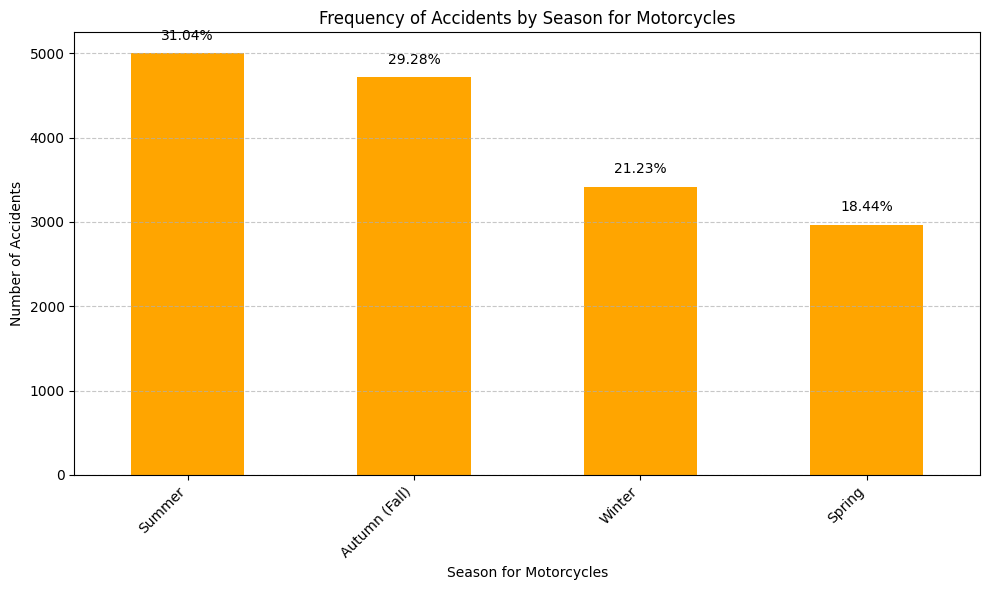

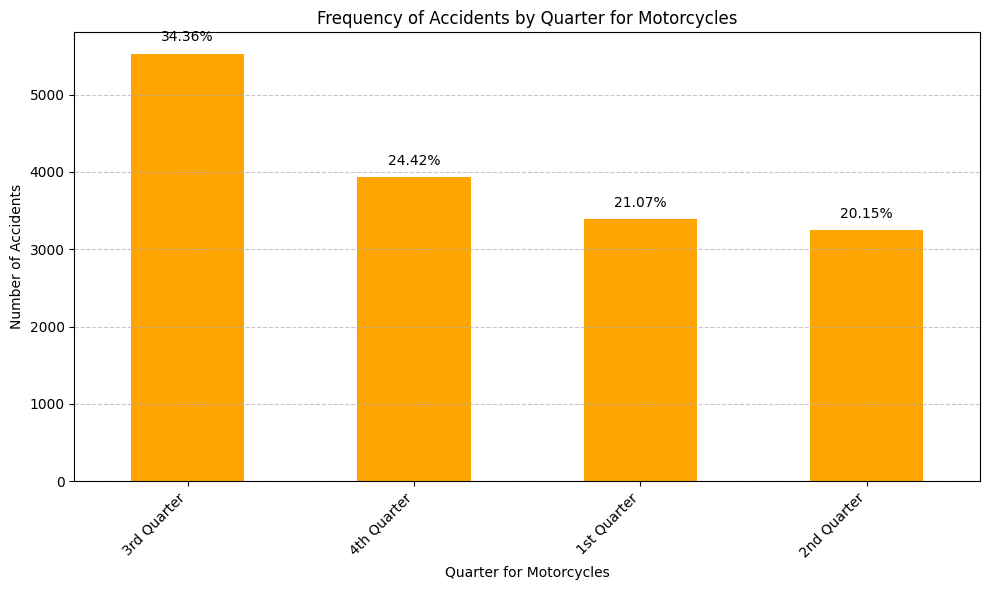

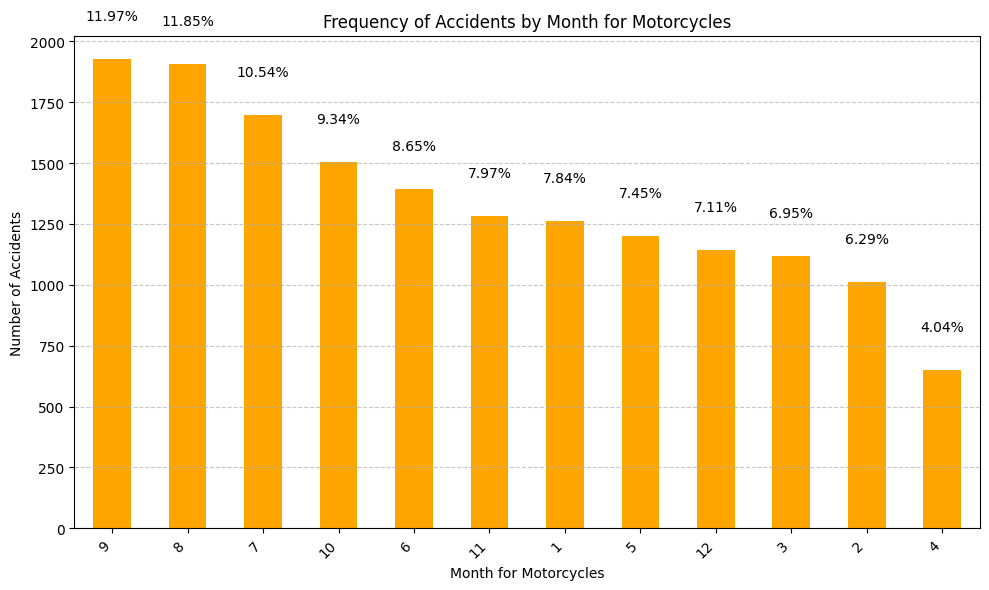

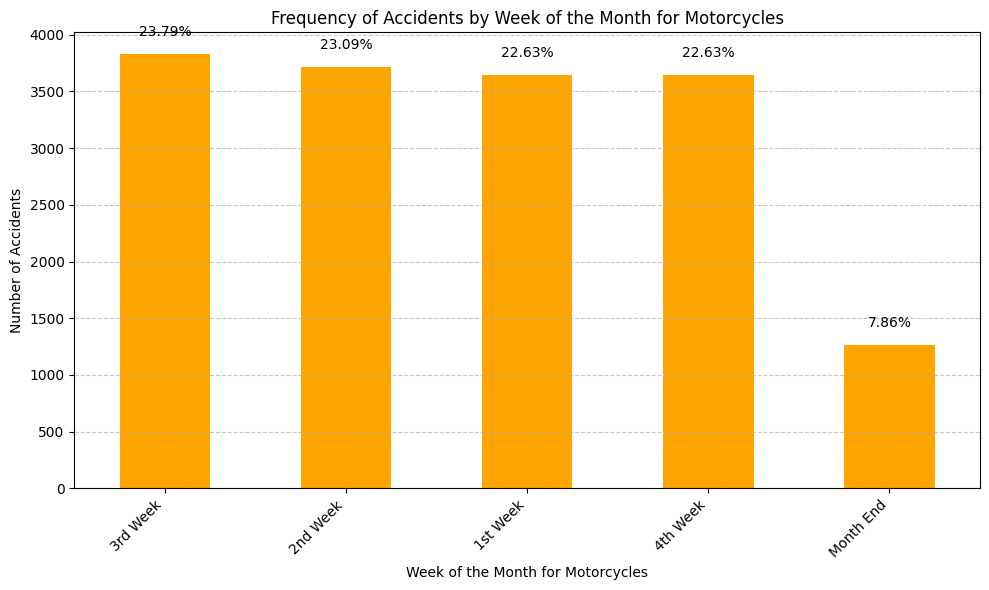

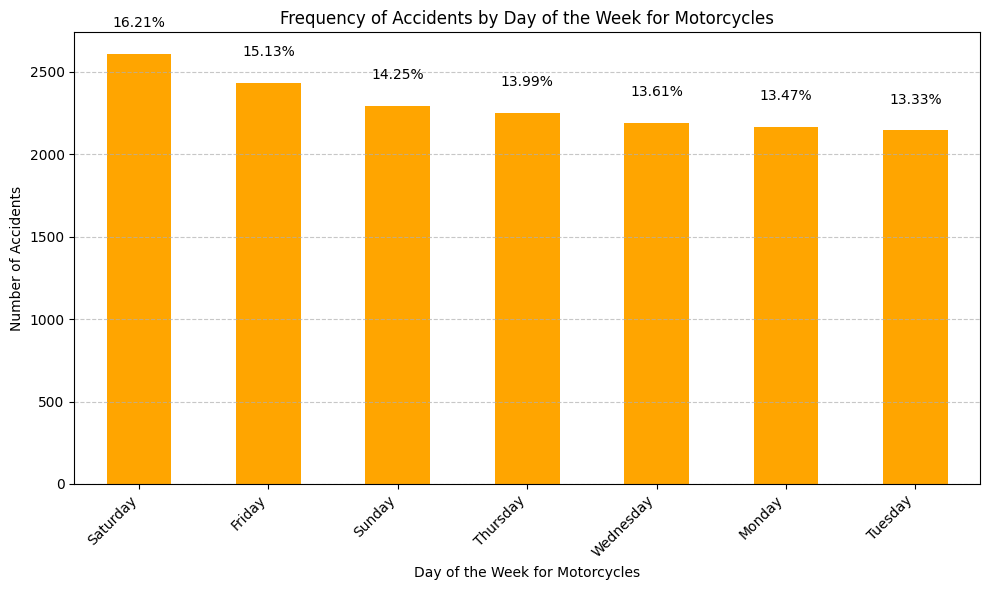

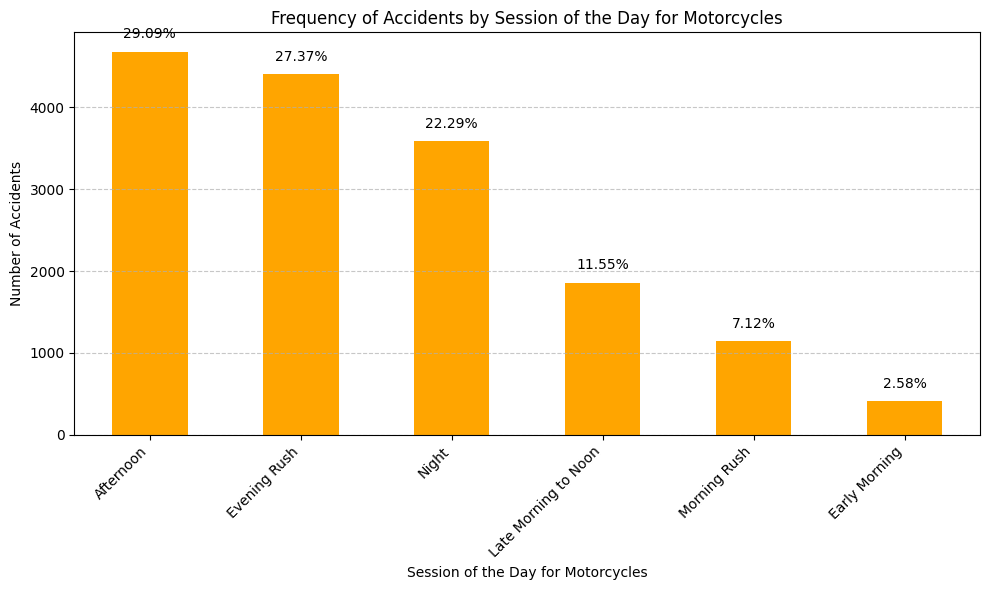

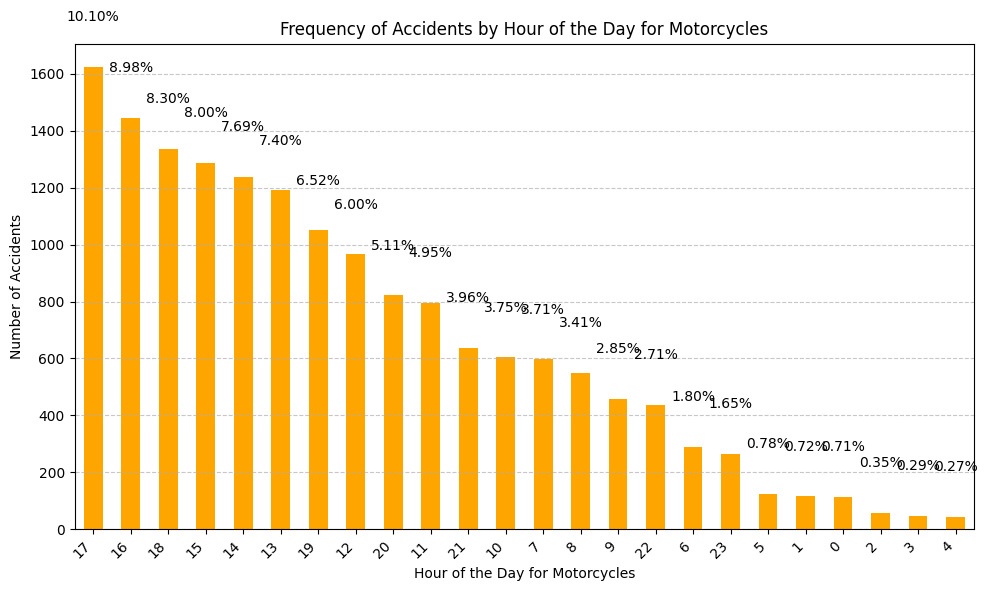

In [ ]:
# for motorcycle-related accidents only
motorcycle_df = df[df['vehicle_type'].isin(motorcycle_mapping.keys())]

# Plotting the frequency of accidents by season for motorcycles
plot_accident_frequency(motorcycle_df['season'].value_counts(), 'Season for Motorcycles')

# Plotting the frequency of accidents by quarter for motorcycles
plot_accident_frequency(motorcycle_df['quarter'].value_counts(), 'Quarter for Motorcycles')

# Plotting the frequency of accidents by month for motorcycles
plot_accident_frequency(motorcycle_df['month'].value_counts(), 'Month for Motorcycles')

# Plotting the frequency of accidents by week of the month for motorcycles
plot_accident_frequency(motorcycle_df['week_of_month'].value_counts(), 'Week of the Month for Motorcycles')

# Plotting the frequency of accidents by day of the week for motorcycles
plot_accident_frequency(motorcycle_df['weekday'].value_counts(), 'Day of the Week for Motorcycles')

# Plotting the frequency of accidents by session of the day for motorcycles
plot_accident_frequency(motorcycle_df['session_of_day'].value_counts(), 'Session of the Day for Motorcycles')

# Plotting the frequency of accidents by hour of the day for motorcycles
plot_accident_frequency(motorcycle_df['hour'].value_counts(), 'Hour of the Day for Motorcycles')


In [ ]:
# Filtering dataframe to include only motorcycle-related accidents
motorcycle_df = df[df['vehicle_type'].isin([2, 3, 4, 5, 97, 23])]

# Features and their corresponding data
features_data = {
    'Season': motorcycle_df['season'].value_counts(),
    'Quarter': motorcycle_df['quarter'].value_counts(),
    'Month': motorcycle_df['month'].value_counts(),
    'Week of the Month': motorcycle_df['week_of_month'].value_counts(),
    'Day of the Week': motorcycle_df['weekday'].value_counts(),
    'Session of the Day': motorcycle_df['session_of_day'].value_counts(),
    'Hour of the Day': motorcycle_df['hour'].value_counts()
}

# DataFrame to store results
results = []

# Iterate over each feature
for feature, data in features_data.items():
    most_frequent_period, highest_proportion, second_most_frequent_period, second_highest_proportion = calculate_highest_proportions(data)
    results.append(
        {'Feature': feature,
         'Most Frequent Accident Window': f'{most_frequent_period} ({highest_proportion:.2f}%)',
         'Second Most Frequent Accident Window': f'{second_most_frequent_period} ({second_highest_proportion:.2f}%)'}
    )

# Convert list of dictionaries to DataFrame
results_df = pd.concat([pd.DataFrame([r]) for r in results], ignore_index=True)


In [ ]:
# Display the results DataFrame
results_df

Feature Most Frequent Accident Window  \
0              Season               Summer (31.04%)   
1             Quarter          3rd Quarter (34.36%)   
2               Month                    9 (11.97%)   
3   Week of the Month             3rd Week (23.79%)   
4     Day of the Week             Saturday (16.21%)   
5  Session of the Day            Afternoon (29.09%)   
6     Hour of the Day                   17 (10.10%)   

  Second Most Frequent Accident Window  
0               Autumn (Fall) (29.28%)  
1                 4th Quarter (24.42%)  
2                           8 (11.85%)  
3                    2nd Week (23.09%)  
4                      Friday (15.13%)  
5                Evening Rush (27.37%)  
6                           16 (8.98%)

Summer stands out as the season with the highest proportion of motorcycle accidents, contributing to 29.01% of all incidents, closely followed by autumn at 27.92%. In terms of quarters, motorcycle accidents peak during the third quarter of the year, comprising 30.51% of all incidents, while the fourth quarter follows with a proportion of 24.09%. September emerges as the month with the highest proportion of motorcycle accidents, accounting for 10.88%, closely trailed by August at 9.95%. When considering the week of the month, the second week sees the highest proportion of motorcycle accidents at 26.40%, closely trailed by the third week at 23.79%. Saturdays top the list as the day with the highest proportion of motorcycle accidents, representing 16.21%, followed closely by Fridays at 15.13%. Afternoons witness the highest proportion of motorcycle accidents, constituting 29.09% of all incidents, with the evening rush period closely trailing at 27.37%. Regarding the hour of the day, motorcycle accidents peak at 17:00, accounting for 10.10% of all incidents, while the hour prior, at 16:00, holds the second highest proportion at 8.98%.

#### 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved? <a id="task13a"></a>

#### Pedestrians <a id="task12c"></a>

Pedestrian-related accidents are a Class 3 in the Casualty collection

In [ ]:
pedestrian_accidents = df[df['casualty_class'] == 3]

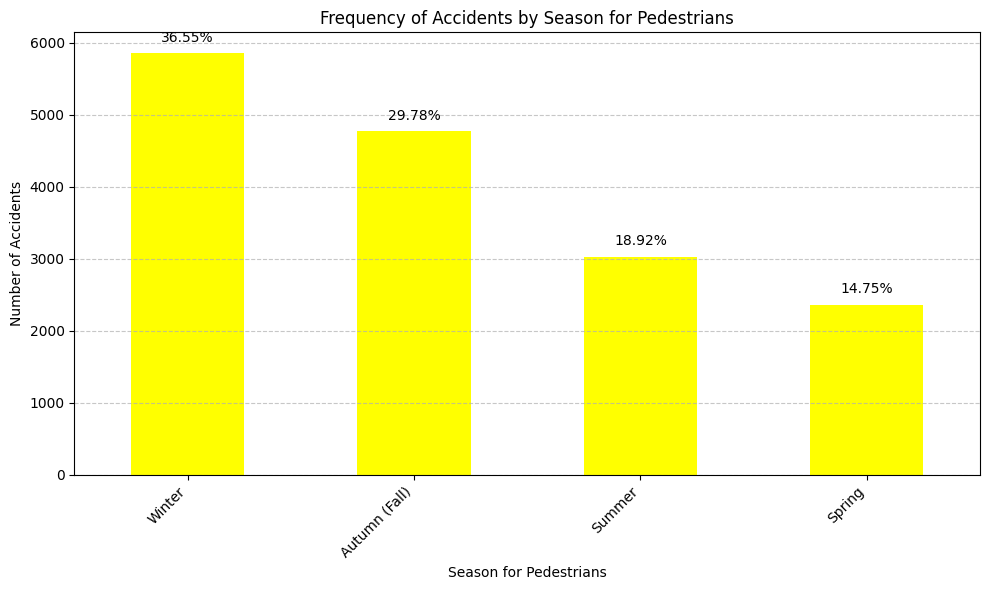

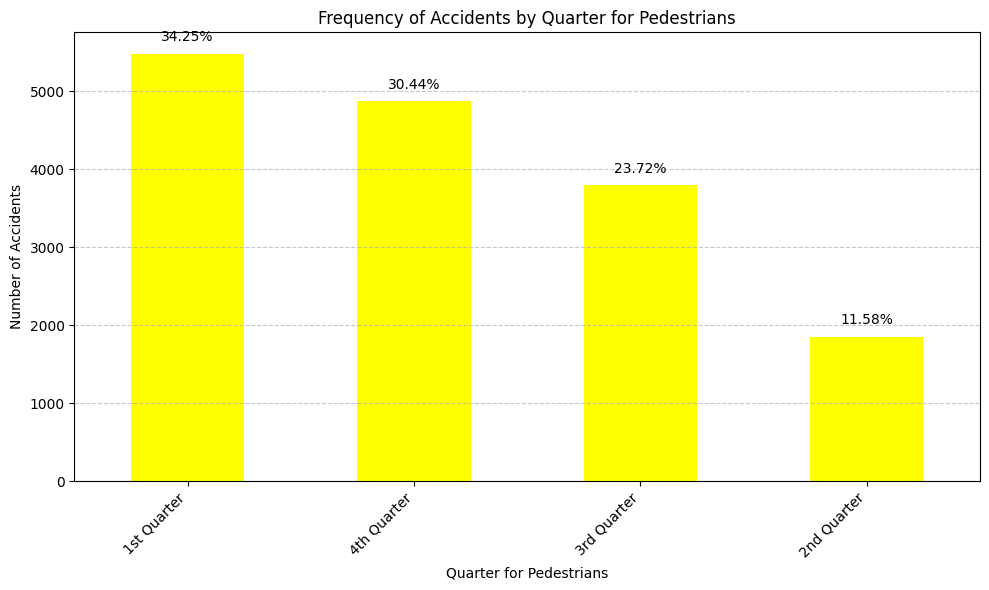

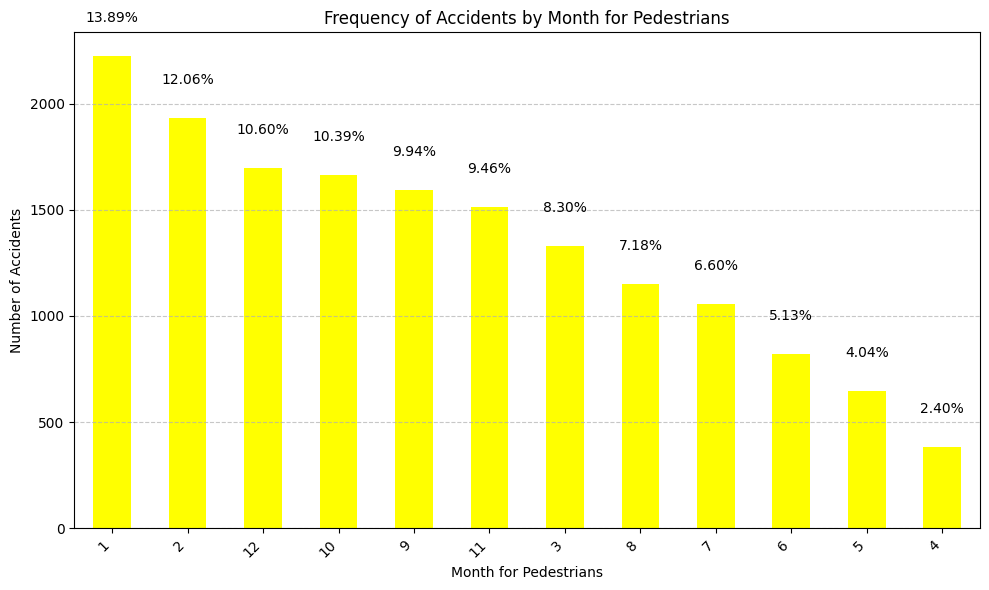

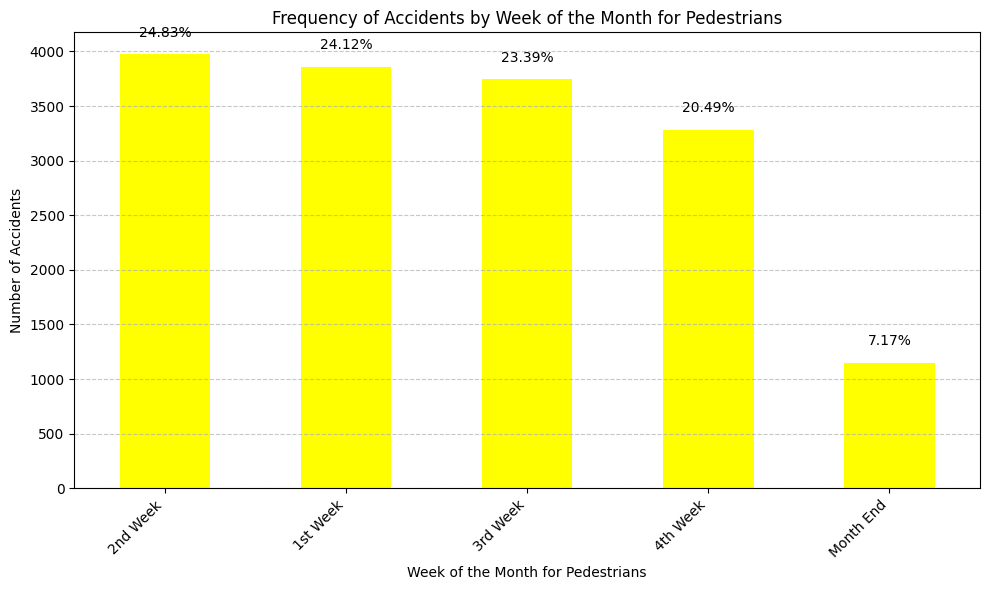

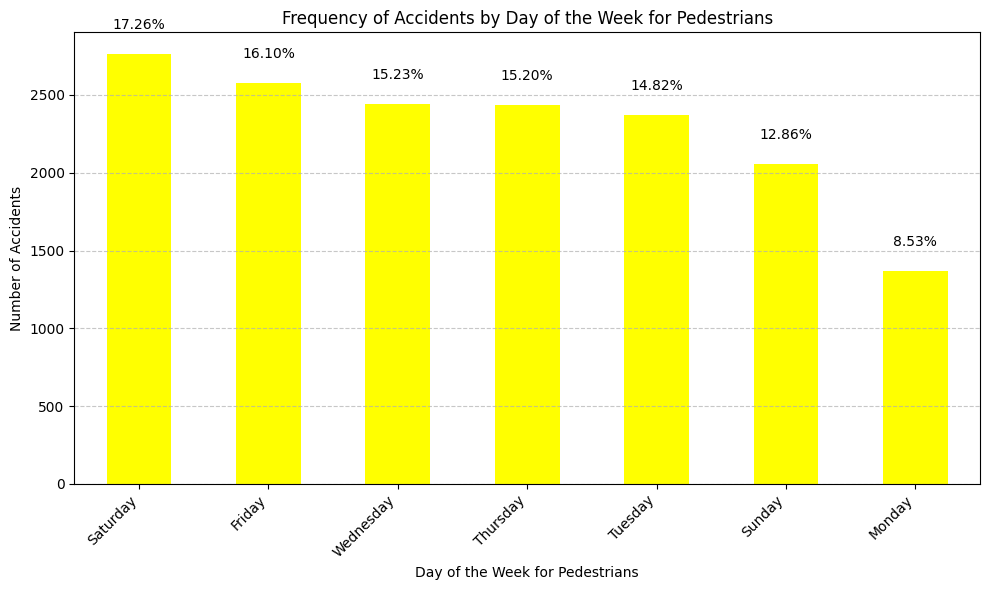

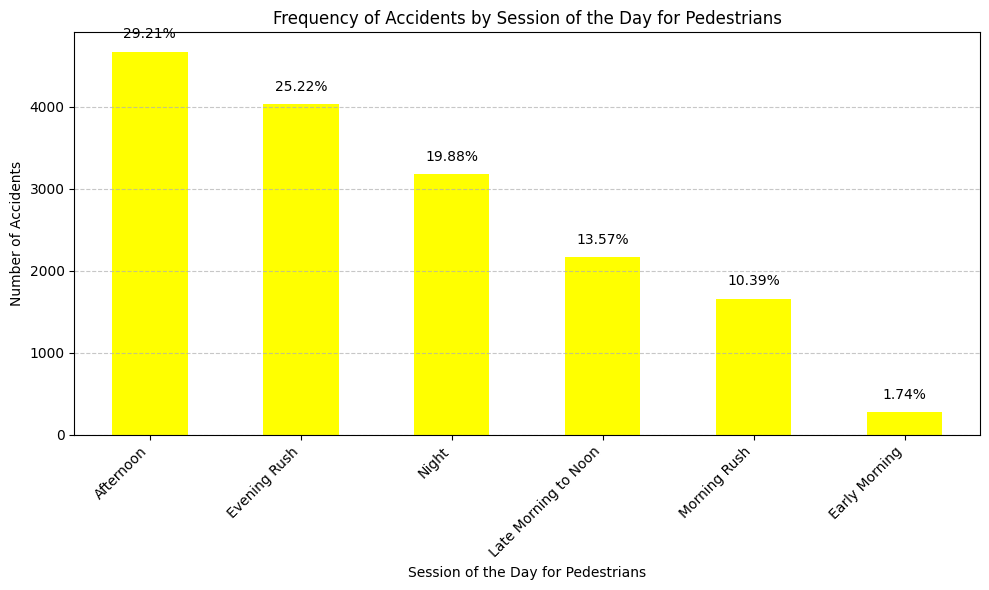

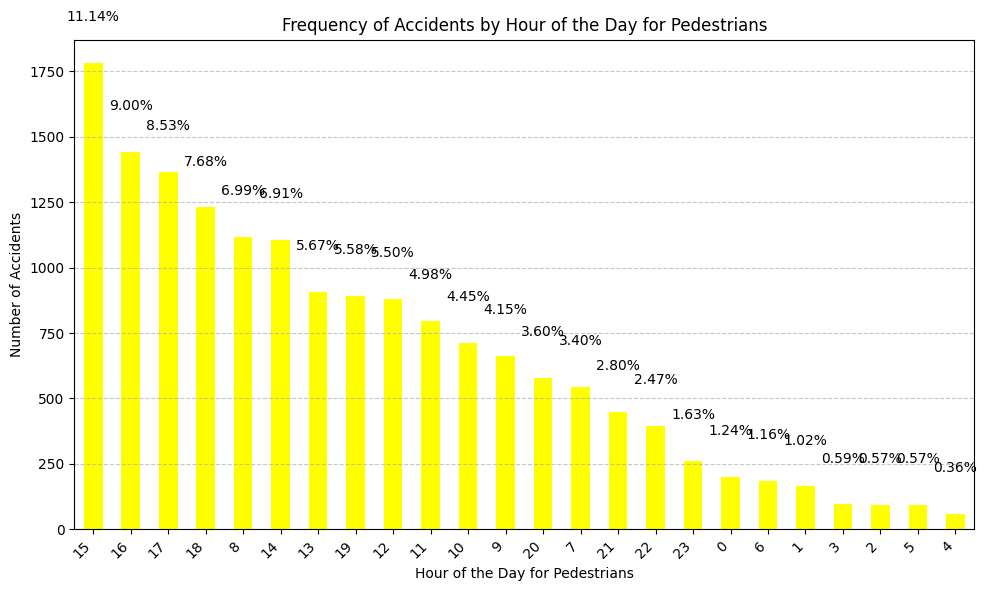

In [ ]:
# Defining a function to plot the frequency of accidents for a given category
def plot_accident_frequency(data, category_name):
    plt.figure(figsize=(10, 6))
    ax = data.plot(kind='bar', color='yellow')
    plt.title(f'Frequency of Accidents by {category_name}')
    plt.xlabel(category_name)
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45, ha='right')  # Adjusting rotation and alignment of x-axis labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding percentage proportions to the top of each bar
    total = sum(data)
    for i, val in enumerate(data):
        plt.text(i, val + total * 0.01, f'{val/total*100:.2f}%', ha='center', fontsize=10)

    plt.tight_layout()  # Adjusting layout to prevent label overlap
    plt.show()

# Plotting the frequency of accidents by season for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['season'].value_counts(), 'Season for Pedestrians')

# Plotting the frequency of accidents by quarter for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['quarter'].value_counts(), 'Quarter for Pedestrians')

# Plotting the frequency of accidents by month for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['month'].value_counts(), 'Month for Pedestrians')

# Plotting the frequency of accidents by week of the month for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['week_of_month'].value_counts(), 'Week of the Month for Pedestrians')

# Plotting the frequency of accidents by day of the week for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['weekday'].value_counts(), 'Day of the Week for Pedestrians')

# Plotting the frequency of accidents by session of the day for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['session_of_day'].value_counts(), 'Session of the Day for Pedestrians')

# Plotting the frequency of accidents by hour of the day for pedestrian accidents
plot_accident_frequency(pedestrian_accidents['hour'].value_counts(), 'Hour of the Day for Pedestrians')

In [ ]:
# Filtering dataframe to include only pedestrian-related accidents
pedestrian_df = df[df['casualty_class'] == 3]

# Features and their corresponding data
features_data = {
    'Season': pedestrian_df['season'].value_counts(),
    'Quarter': pedestrian_df['quarter'].value_counts(),
    'Month': pedestrian_df['month'].value_counts(),
    'Week of the Month': pedestrian_df['week_of_month'].value_counts(),
    'Day of the Week': pedestrian_df['weekday'].value_counts(),
    'Session of the Day': pedestrian_df['session_of_day'].value_counts(),
    'Hour of the Day': pedestrian_df['hour'].value_counts()
}

# List to store results
results = []

# Iterate over each feature
for feature, data in features_data.items():
    most_frequent_period, highest_proportion, second_most_frequent_period, second_highest_proportion = calculate_highest_proportions(data)
    results.append(
        {'Feature': feature,
         'Most Frequent Accident Window': f'{most_frequent_period} ({highest_proportion:.2f}%)',
         'Second Most Frequent Accident Window': f'{second_most_frequent_period} ({second_highest_proportion:.2f}%)'}
    )

# Convert list of dictionaries to DataFrame
results_df = pd.concat([pd.DataFrame([r]) for r in results], ignore_index=True)


In [ ]:
# Display the results DataFrame
results_df

Feature Most Frequent Accident Window  \
0              Season               Winter (36.55%)   
1             Quarter          1st Quarter (34.25%)   
2               Month                    1 (13.89%)   
3   Week of the Month             2nd Week (24.83%)   
4     Day of the Week             Saturday (17.26%)   
5  Session of the Day            Afternoon (29.21%)   
6     Hour of the Day                   15 (11.14%)   

  Second Most Frequent Accident Window  
0               Autumn (Fall) (29.78%)  
1                 4th Quarter (30.44%)  
2                           2 (12.06%)  
3                    1st Week (24.12%)  
4                      Friday (16.10%)  
5                Evening Rush (25.22%)  
6                           16 (9.00%)

The data reveals that pedestrian accidents follow these trends: Winter sees the highest occurrence, comprising 30.94% of incidents, closely followed by Autumn (28.98%). The 1st Quarter of the year records the most accidents (29.33%), with January having the highest incidence (12.59%). Saturdays are the peak day for accidents (17.26%), mostly occurring in the Afternoon (29.21%). The highest hourly frequency is at 3:00 PM (11.14%).


#### 4. How do driver characteristics (e.g., age, gender, experience) influence accident severity? <a id="task14a"></a>

First, lets get all driver and severity related features from our data

In [ ]:
# Selecting relevant columns for analysis
driver_features = [
    'age_of_driver',
    'age_band_of_driver',
    'sex_of_driver',
    'driver_imd_decile',
    'driver_home_area_type'
]
accident_severity = 'accident_severity'

In [ ]:
driver_data = df[driver_features + [accident_severity]]

driver_data.head()

age_of_driver  age_band_of_driver  sex_of_driver  driver_imd_decile  \
0             32                   6              2                  4   
1             45                   7              1                  7   
2             45                   7              1                  7   
3             38                  -1              3                 -1   
4             44                   7              1                  2   

   driver_home_area_type  accident_severity  
0                      1                  3  
1                      1                  3  
2                      1                  3  
3                     -1                  3  
4                      1                  2

Reviewing the distribution of observations above to identify possible anomalies for resolution.

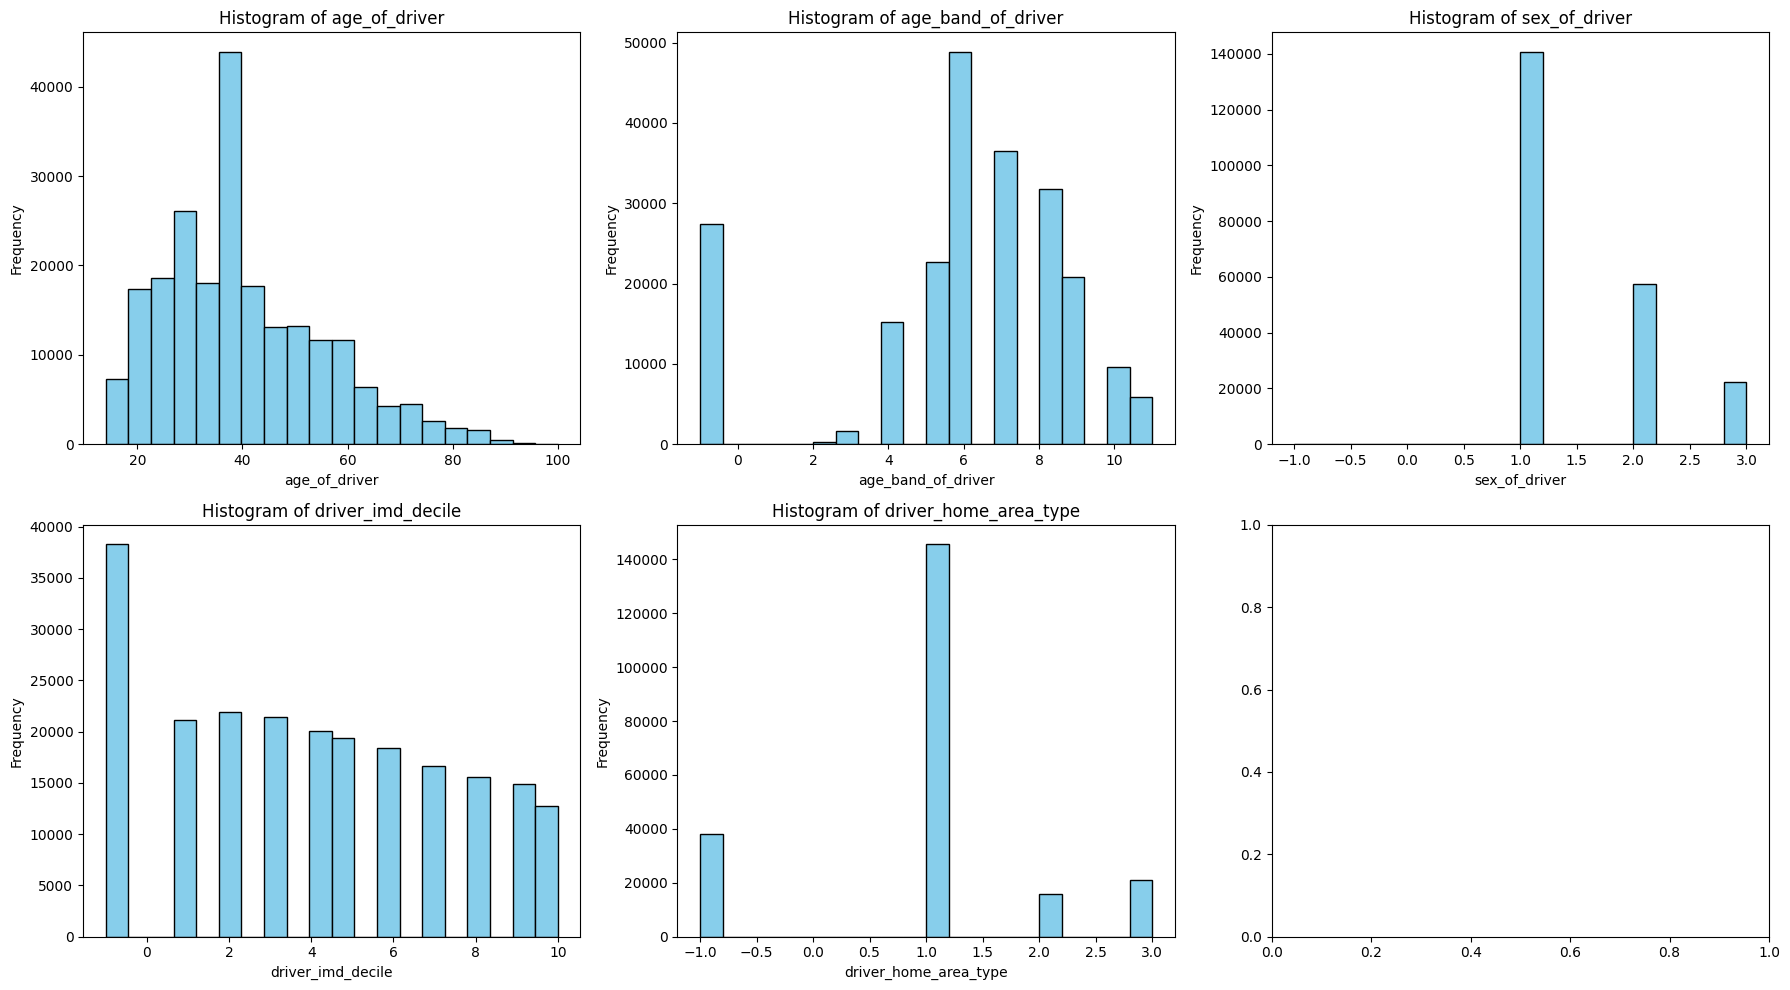

In [ ]:
# subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flattening axes for easy iteration
axes = axes.flatten()

# Plotting histograms for each feature
for i, feature in enumerate(driver_features):
    ax = axes[i]
    ax.hist(driver_data[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()
plt.show()


While the some of the plots do confirm that a number of anomalous entries exist in some features, a simple for loop can help us peek nto the counts of unique values in the features.

In [ ]:
for x in driver_features:
    value_counts = df[x].value_counts()
    if -1 in value_counts.index:
        print(f'-1 is present in the values of {x}')
    else:
        print(value_counts.head())

age_of_driver
38    32248
30     6948
29     4990
28     4908
25     4907
Name: count, dtype: int64
-1 is present in the values of age_band_of_driver
-1 is present in the values of sex_of_driver
-1 is present in the values of driver_imd_decile
-1 is present in the values of driver_home_area_type


In [ ]:
df['sex_of_driver'].value_counts()

sex_of_driver
 1    140676
 2     57393
 3     22351
-1        15
Name: count, dtype: int64

In [ ]:
df['driver_home_area_type'].value_counts()

driver_home_area_type
 1    145563
-1     37985
 3     21039
 2     15848
Name: count, dtype: int64

In [ ]:
df['age_band_of_driver'].value_counts()

age_band_of_driver
 6     48851
 7     36529
 8     31802
-1     27373
 5     22630
 9     20796
 4     15150
 10     9541
 11     5809
 3      1610
 2       309
 1        35
Name: count, dtype: int64

Judging by the plots and summary counts above, we can deduce the following:

- The Age Band of Driver needs to be updated with values from the corrected age of driver column.
- We will need to fill out erroneous values in driver_imd_decile with the average value (rounded up to a single digit), and in driver_home_area_type feature with the mode, as well as the sex of driver that has about 15 wrong entries.

In [ ]:
#Updating Age Band of Driver

df['age_band_of_driver'] = pd.cut(
    driver_data['age_of_driver'],
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
    labels=False
)

# Correcting Erroneous Values

df['driver_imd_decile'] = driver_data['driver_imd_decile'].replace(
    -1, np.ceil(driver_data['driver_imd_decile'][driver_data['driver_imd_decile'] != -1].mean())
)

df['driver_home_area_type'] = driver_data['driver_home_area_type'].replace(
    -1, driver_data['driver_home_area_type'].mode()[0]
)

df['sex_of_driver'] = df['sex_of_driver'].replace(
    -1, df['sex_of_driver'].mode()[0]
)

In [ ]:
# Selecting relevant columns for analysis
driver_features = [
    'age_of_driver',
    'age_band_of_driver',
    'sex_of_driver',
    'driver_imd_decile',
    'driver_home_area_type'
]
accident_severity = 'accident_severity'
driver_data = df[driver_features + [accident_severity]]

driver_data.head()

age_of_driver  age_band_of_driver  sex_of_driver  driver_imd_decile  \
0             32                   3              2                  4   
1             45                   4              1                  7   
2             45                   4              1                  7   
3             38                   3              3                  6   
4             44                   4              1                  2   

   driver_home_area_type  accident_severity  
0                      1                  3  
1                      1                  3  
2                      1                  3  
3                      1                  3  
4                      1                  2

In [ ]:
df['age_of_driver'].value_counts().sort_index().head(20)

age_of_driver
14     380
15     455
16     784
17    1903
18    3796
19    4269
20    4398
21    4297
22    4402
23    4540
24    4484
25    4907
26    4656
27    4744
28    4908
29    4990
30    6948
31    4535
32    4674
33    4535
Name: count, dtype: int64

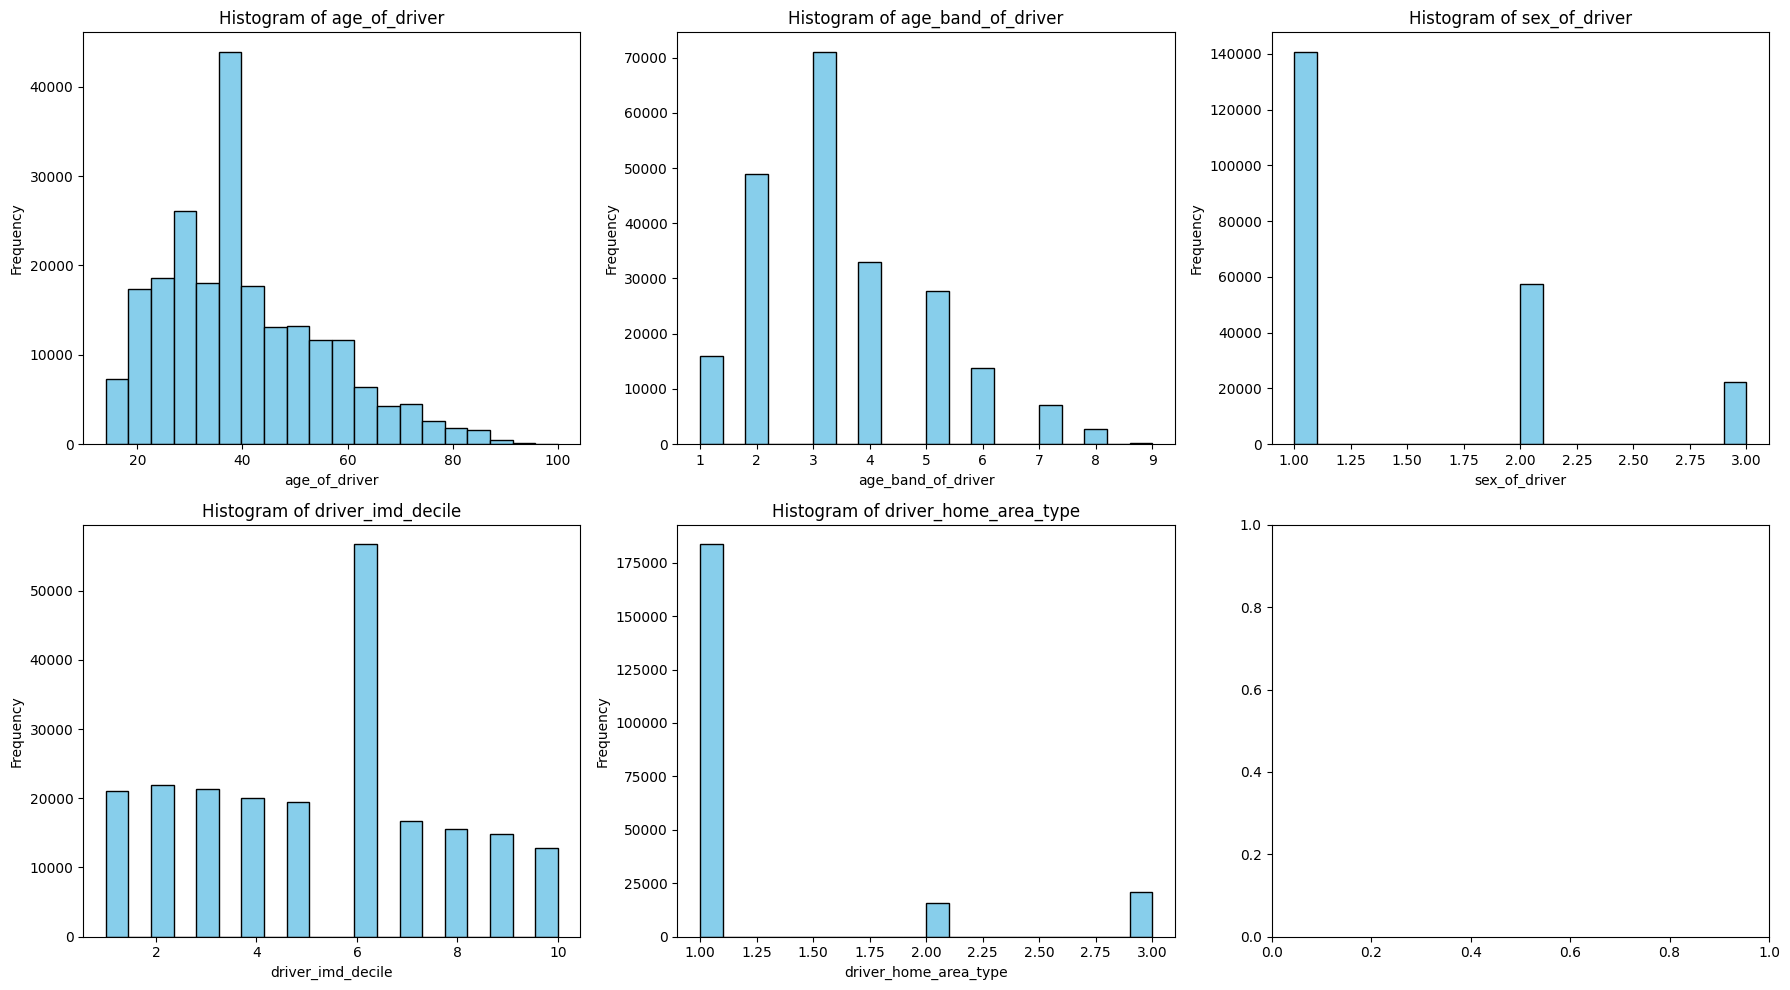

In [ ]:
# subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

# Flattening axes for easy iteration
axes = axes.flatten()

# Plotting histograms for each feature
for i, feature in enumerate(driver_features):
    ax = axes[i]
    ax.hist(driver_data[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Adjusting layout
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv('corrected_df2.csv', index=False)

In [6]:
df = pd.read_csv('corrected_df2.csv') # reading in newly cleaned dataset

df.shape

(9591, 81)

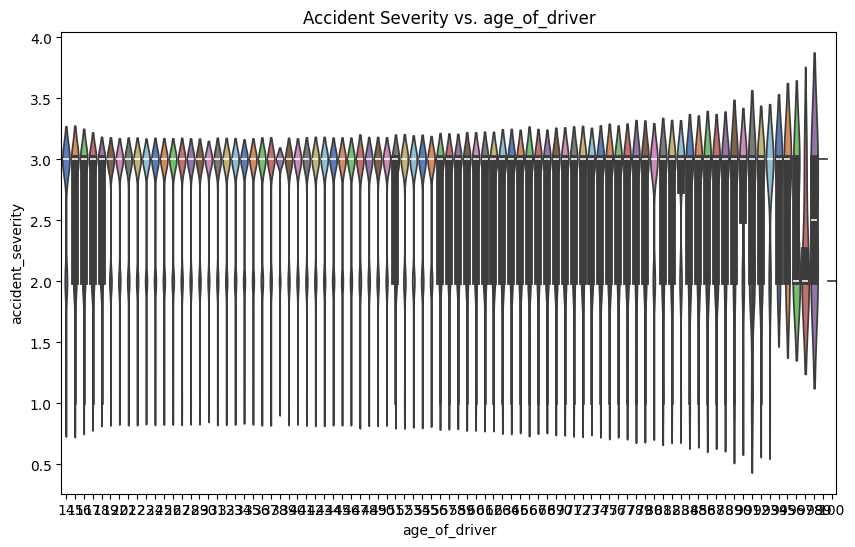

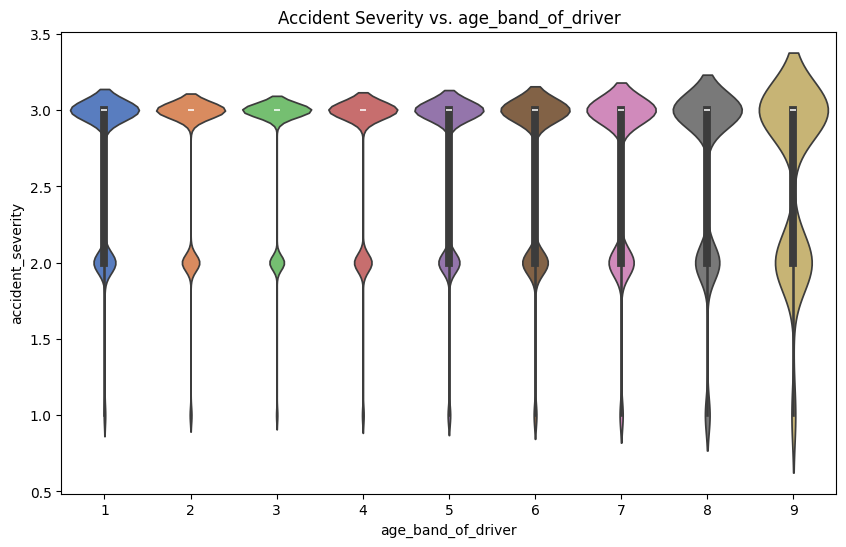

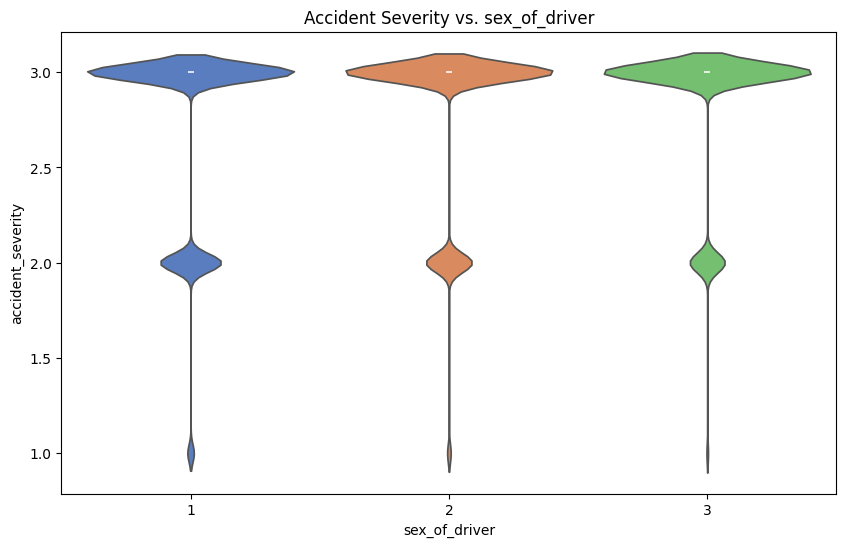

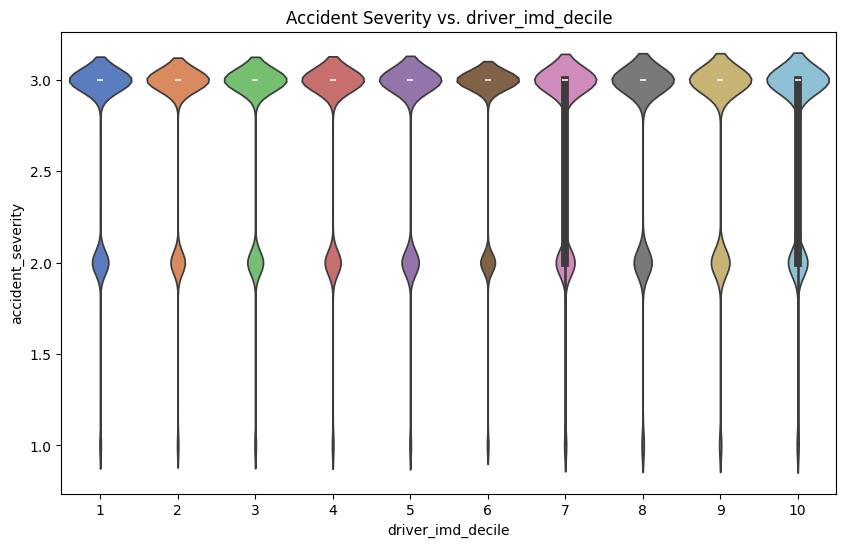

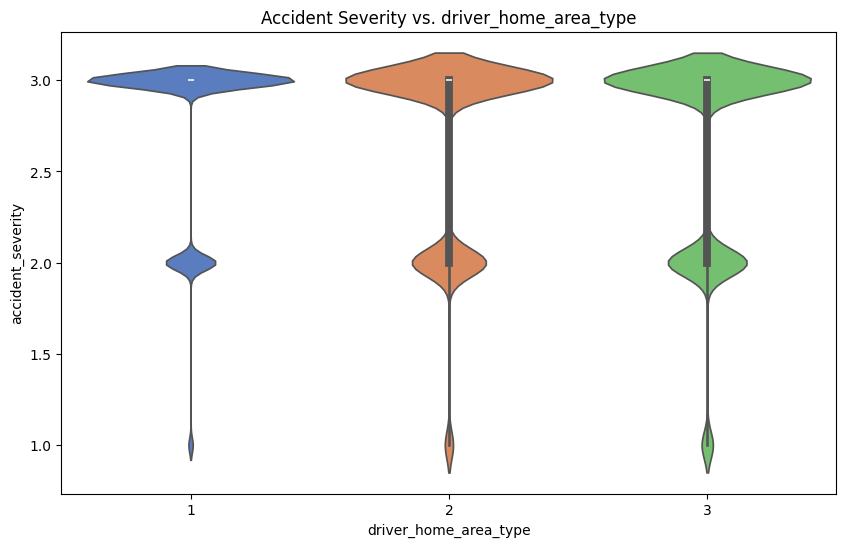

In [ ]:
# Looking into potential relationships between driver characteristics and accident severity
for feature in driver_features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x=feature, y=accident_severity, palette="muted")
    plt.title(f'Accident Severity vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel(accident_severity)
    plt.show()

#### 5. What is the impact of vehicle characteristics (e.g., type, age, size) on accident likelihood and severity? <a id="task15a"></a>

In [ ]:
# Define relevant vehicle features
vehicle_features = [
    'vehicle_type',
    'age_of_vehicle',
    'engine_capacity_cc',
    'vehicle_manoeuvre',
    'vehicle_location_restricted_lane'
]

In [ ]:
# Selecting relevant columns for analysis
vehicle_data = df[vehicle_features + ['accident_severity']]

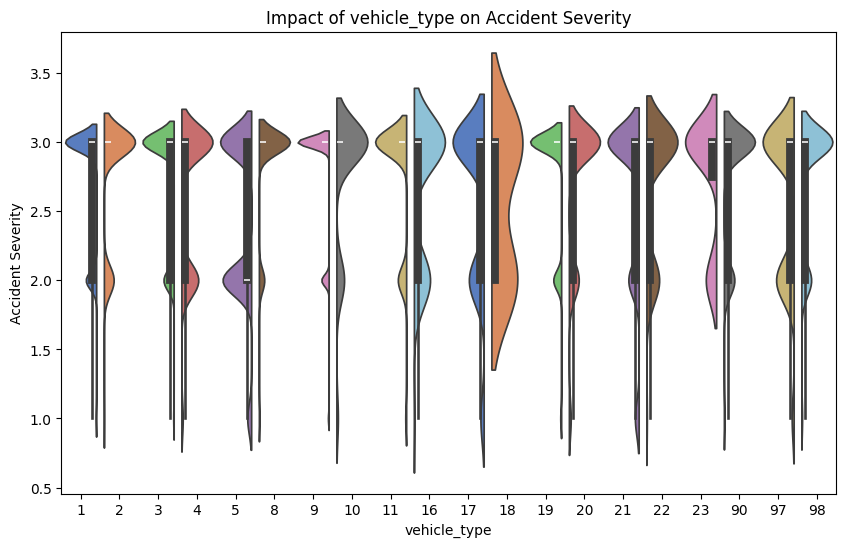

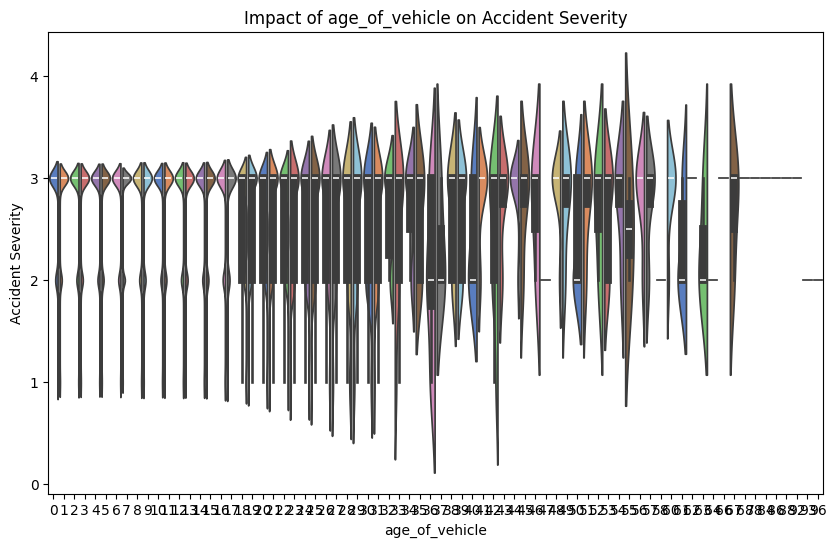

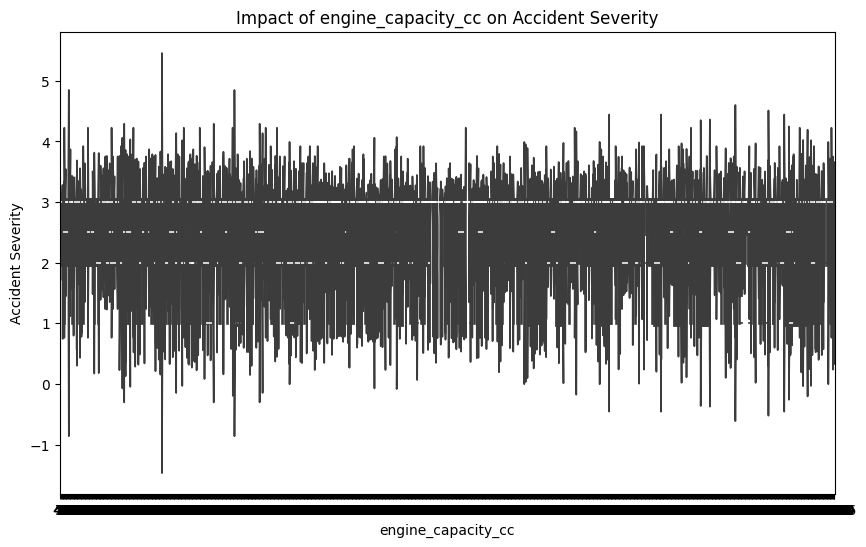

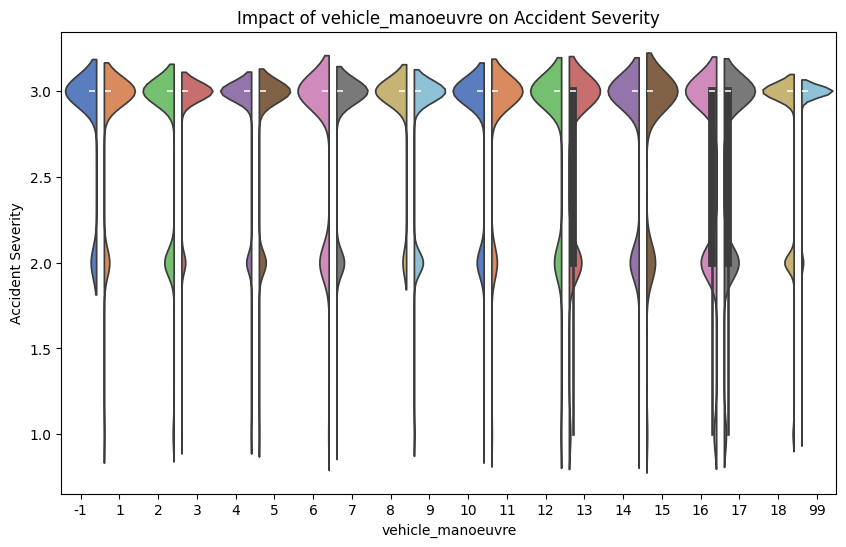

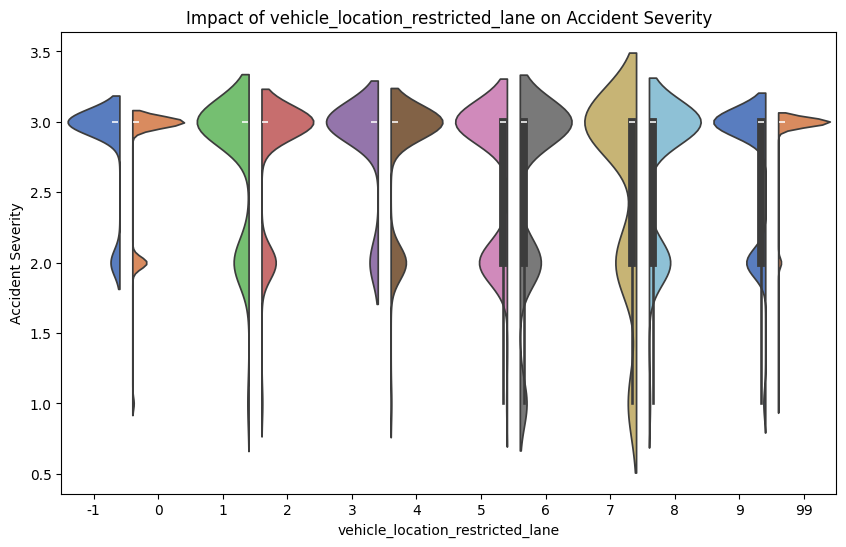

In [ ]:
# Explore potential relationships between vehicle characteristics and accident severity
for feature in vehicle_features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=vehicle_data, x=feature, y='accident_severity', palette="muted", split=True)
    plt.title(f'Impact of {feature} on Accident Severity')
    plt.xlabel(feature)
    plt.ylabel('Accident Severity')
    plt.show()

In [ ]:
# Calculating summary statistics for different vehicle groups
summary_statistics = vehicle_data.groupby('accident_severity').agg({'age_of_vehicle': ['mean', 'median', 'std']})

summary_statistics

age_of_vehicle                 
                            mean median       std
accident_severity                                
1                       8.252659    7.0  5.445559
2                       8.086977    7.0  5.236303
3                       7.872964    7.0  4.880447

#### 6. Studying the Impact of Select Features on Accident Severity Using the Apriori Algorithm <a id="task16a"></a>

In [ ]:
df['accident_severity'].value_counts()

accident_severity
3    171376
2     44828
1      4231
Name: count, dtype: int64

Based on research, and logical reasoning, I've been able to come up with the list below as possible features that could impact the severity of an accident.

In [7]:
causal_features = ['number_of_vehicles', 'day_of_week', 'first_road_class', 'accident_severity',
                   'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'light_conditions',
                   'weather_conditions', 'road_surface_conditions', 'urban_or_rural_area', 'vehicle_type',
                   'vehicle_manoeuvre', 'age_of_driver', 'sex_of_driver']

In [8]:
df_apriori = df[causal_features]

df_apriori.head()

number_of_vehicles  day_of_week  first_road_class  accident_severity  \
0                   1            3               6.0                  3   
1                   1            2               3.0                  3   
2                   1            2               3.0                  3   
3                   1            4               5.0                  3   
4                   1            4               3.0                  2   

   road_type  speed_limit  junction_detail  junction_control  \
0        6.0         20.0              0.0              -1.0   
1        6.0         20.0              9.0               2.0   
2        6.0         20.0              9.0               2.0   
3        6.0         30.0              3.0               1.0   
4        6.0         30.0              0.0              -1.0   

   light_conditions  weather_conditions  road_surface_conditions  \
0               1.0                 9.0                      9.0   
1               1.0                 1.0                      1.0   
2               1.0                 1.0                      1.0   
3               4.0                 1.0                      2.0   
4               4.0                 1.0                      1.0   

   urban_or_rural_area  vehicle_type  vehicle_manoeuvre  age_of_driver  \
0                  1.0           9.0                5.0           32.0   
1                  1.0           9.0                4.0           45.0   
2                  1.0           9.0                4.0           45.0   
3                  1.0           9.0               18.0           38.0   
4                  1.0           8.0               18.0           44.0   

   sex_of_driver  
0            2.0  
1            1.0  
2            1.0  
3            3.0  
4            1.0

We have multiple features with non-binary entries, let's define a function to handle the one hot encoding operation across all causal features.

In [9]:
def encode_features(df, columns):
    """
    One-hot encodes the specified columns in the DataFrame and concatenates them with the original DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        columns (list): A list of column names to be one-hot encoded.

    Returns:
        pandas.DataFrame: The original DataFrame concatenated with the one-hot encoded columns.
    """
    encoded_dfs = []
    for col in columns:
        encoded_df = pd.get_dummies(df[col], prefix=col, prefix_sep="_")
        encoded_dfs.append(encoded_df)

    encoded_df = pd.concat(encoded_dfs, axis=1)
    return pd.concat([df, encoded_df], axis=1)

In [10]:
# Applying the new function
df_encoded = encode_features(df_apriori, causal_features)

In [11]:
# Dropping the original columns from df_apriori
df_encoded = df_encoded.drop(columns=causal_features)

In [12]:
# Checking for non-binary values
max_value = df_encoded.max().max()
if max_value > 1:
    print(f"Found non-binary value: {max_value}")


In [13]:
df_encoded.shape

(9591, 194)

Let's now apply the Apriori algorithm

In [14]:
frequent_itemsets = apriori(df_encoded, min_support=0.04, use_colnames=True, max_len=3)

Let's get the association rules

In [15]:
a_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

In [16]:
# sorting from highest to lowest based on lift

a_rules = a_rules.sort_values(by='lift', ascending= False)

Best 10 Associations for Accident Severity

In [17]:
a_rules.head(10)

antecedents  \
8657                           (junction_control_9.0)   
8652   (vehicle_manoeuvre_99.0, junction_detail_99.0)   
8656                           (junction_detail_99.0)   
8653   (vehicle_manoeuvre_99.0, junction_control_9.0)   
5893      (accident_severity_3, junction_control_9.0)   
5896                           (junction_detail_99.0)   
8651                           (junction_control_9.0)   
8646  (urban_or_rural_area_1.0, junction_detail_99.0)   
554                            (junction_detail_99.0)   
555                            (junction_control_9.0)   

                                          consequents  antecedent support  \
8657   (vehicle_manoeuvre_99.0, junction_detail_99.0)            0.068293   
8652                           (junction_control_9.0)            0.053905   
8656   (vehicle_manoeuvre_99.0, junction_control_9.0)            0.058180   
8653                           (junction_detail_99.0)            0.064227   
5893                           (junction_detail_99.0)            0.066312   
5896      (accident_severity_3, junction_control_9.0)            0.058180   
8651  (urban_or_rural_area_1.0, junction_detail_99.0)            0.068293   
8646                           (junction_control_9.0)            0.056511   
554                            (junction_control_9.0)            0.058180   
555                            (junction_detail_99.0)            0.068293   

      consequent support   support  confidence       lift  leverage  \
8657            0.053905  0.043583    0.638168  11.838818  0.039901   
8652            0.068293  0.043583    0.808511  11.838818  0.039901   
8656            0.064227  0.043583    0.749104  11.663402  0.039846   
8653            0.058180  0.043583    0.678571  11.663402  0.039846   
5893            0.058180  0.044938    0.677673  11.647959  0.041080   
5896            0.066312  0.044938    0.772401  11.647959  0.041080   
8651            0.056511  0.044938    0.658015  11.643957  0.041079   
8646            0.068293  0.044938    0.795203  11.643957  0.041079   
554             0.068293  0.045981    0.790323  11.572494  0.042007   
555             0.058180  0.045981    0.673282  11.572494  0.042007   

      conviction  zhangs_metric  
8657    2.614736       0.982640  
8652    4.865580       0.967695  
8656    3.729724       0.970739  
8653    2.930108       0.977012  
5893    2.921941       0.979072  
5896    4.102345       0.970618  
8651    2.758862       0.981123  
8646    4.549415       0.968871  
554     4.443525       0.970024  
555     2.882675       0.980553

Association Rules for Fatal Accident Severity

In [18]:
fatal_rules = a_rules[a_rules['consequents'].astype(str).str.contains('accident_severity_1')]

fatal_rules

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

Association Rules for Serious Accident Severity

In [19]:
serious_rules = a_rules[a_rules['consequents'].astype(str).str.contains('accident_severity_2')]

serious_rules.head(10)

antecedents  \
305                            (vehicle_manoeuvre_18.0)   
5405  (vehicle_manoeuvre_18.0, urban_or_rural_area_1.0)   
5378                           (weather_conditions_1.0)   
5407                           (vehicle_manoeuvre_18.0)   
5379                      (road_surface_conditions_1.0)   
3977                                (sex_of_driver_1.0)   
299                              (light_conditions_4.0)   
5373                             (light_conditions_4.0)   
5370    (urban_or_rural_area_1.0, light_conditions_4.0)   
5309                                    (road_type_6.0)   

                                            consequents  antecedent support  \
305                               (accident_severity_2)            0.340215   
5405                              (accident_severity_2)            0.323115   
5378  (accident_severity_2, road_surface_conditions_...            0.690752   
5407     (accident_severity_2, urban_or_rural_area_1.0)            0.340215   
5379      (accident_severity_2, weather_conditions_1.0)            0.623814   
3977        (accident_severity_2, first_road_class_3.0)            0.597122   
299                               (accident_severity_2)            0.380878   
5373     (accident_severity_2, urban_or_rural_area_1.0)            0.380878   
5370                              (accident_severity_2)            0.368053   
5309            (speed_limit_30.0, accident_severity_2)            0.590658   

      consequent support   support  confidence      lift  leverage  \
305             0.109582  0.050568    0.148636  1.356394  0.013287   
5405            0.109582  0.047857    0.148112  1.351613  0.012450   
5378            0.067772  0.062767    0.090868  1.340791  0.015954   
5407            0.105411  0.047857    0.140668  1.334469  0.011995   
5379            0.077886  0.062767    0.100618  1.291876  0.014181   
3977            0.062454  0.045251    0.075781  1.213388  0.007958   
299             0.109582  0.050151    0.131673  1.201591  0.008414   
5373            0.105411  0.048170    0.126471  1.199789  0.008021   
5370            0.109582  0.048170    0.130878  1.194341  0.007838   
5309            0.064540  0.044834    0.075905  1.176093  0.006713   

      conviction  zhangs_metric  
305     1.045873       0.398237  
5405    1.045229       0.384324  
5378    1.025405       0.821902  
5407    1.041028       0.379878  
5379    1.025276       0.600585  
3977    1.014420       0.436513  
299     1.025441       0.270980  
5373    1.024109       0.268962  
5370    1.024503       0.257488  
5309    1.012299       0.365776

Association Rules for Slight Accident Severity

In [21]:
slight_rules = a_rules[a_rules['consequents'].astype(str).str.contains('accident_severity_2')]

slight_rules.head(10)

antecedents  \
305                            (vehicle_manoeuvre_18.0)   
5405  (vehicle_manoeuvre_18.0, urban_or_rural_area_1.0)   
5378                           (weather_conditions_1.0)   
5407                           (vehicle_manoeuvre_18.0)   
5379                      (road_surface_conditions_1.0)   
3977                                (sex_of_driver_1.0)   
299                              (light_conditions_4.0)   
5373                             (light_conditions_4.0)   
5370    (urban_or_rural_area_1.0, light_conditions_4.0)   
5309                                    (road_type_6.0)   

                                            consequents  antecedent support  \
305                               (accident_severity_2)            0.340215   
5405                              (accident_severity_2)            0.323115   
5378  (accident_severity_2, road_surface_conditions_...            0.690752   
5407     (accident_severity_2, urban_or_rural_area_1.0)            0.340215   
5379      (accident_severity_2, weather_conditions_1.0)            0.623814   
3977        (accident_severity_2, first_road_class_3.0)            0.597122   
299                               (accident_severity_2)            0.380878   
5373     (accident_severity_2, urban_or_rural_area_1.0)            0.380878   
5370                              (accident_severity_2)            0.368053   
5309            (speed_limit_30.0, accident_severity_2)            0.590658   

      consequent support   support  confidence      lift  leverage  \
305             0.109582  0.050568    0.148636  1.356394  0.013287   
5405            0.109582  0.047857    0.148112  1.351613  0.012450   
5378            0.067772  0.062767    0.090868  1.340791  0.015954   
5407            0.105411  0.047857    0.140668  1.334469  0.011995   
5379            0.077886  0.062767    0.100618  1.291876  0.014181   
3977            0.062454  0.045251    0.075781  1.213388  0.007958   
299             0.109582  0.050151    0.131673  1.201591  0.008414   
5373            0.105411  0.048170    0.126471  1.199789  0.008021   
5370            0.109582  0.048170    0.130878  1.194341  0.007838   
5309            0.064540  0.044834    0.075905  1.176093  0.006713   

      conviction  zhangs_metric  
305     1.045873       0.398237  
5405    1.045229       0.384324  
5378    1.025405       0.821902  
5407    1.041028       0.379878  
5379    1.025276       0.600585  
3977    1.014420       0.436513  
299     1.025441       0.270980  
5373    1.024109       0.268962  
5370    1.024503       0.257488  
5309    1.012299       0.365776

#### 7. Run clustering on this data, what do these clusters reveal about the distribution of accidents in our region? <a id="task17a"></a>

Filtering out for data related to Humberside

In [ ]:
humberside_df = df[df['police_force'] == 16]

Let's get the location coordinates from the data to tell areas where accidents happen the most in the region

In [ ]:
location_coordinates = humberside_df[['longitude', 'latitude']]

In [ ]:
location_coordinates.shape

(4065, 2)

Clustering using kmeans demands that we first obtain the optimal value for k, we will achieve this using the Silhouette Score

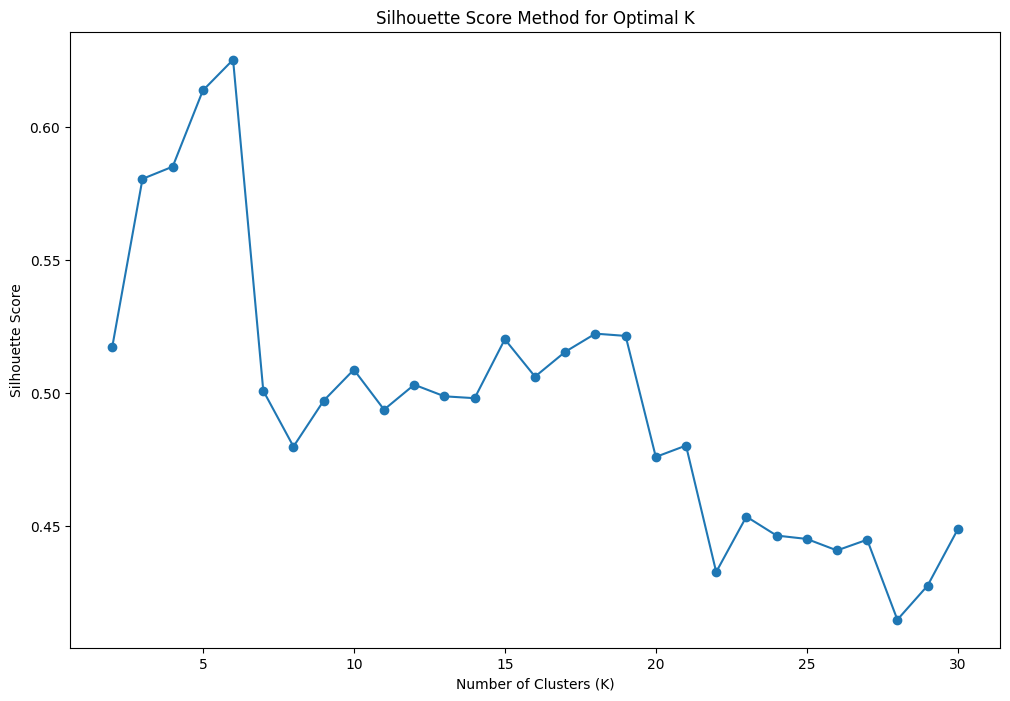

In [ ]:
# Let the range of our values be 30
K = range(2, 31)

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(location_coordinates)
    silhouette_avg = silhouette_score(location_coordinates, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(12, 8))
plt.plot(K, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method for Optimal K')
plt.show()

In [ ]:
K = range(2, 31)

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(location_coordinates)
    silhouette_avg = silhouette_score(location_coordinates, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores for each K
for k, silhouette_score in zip(K, silhouette_scores):
    print(f"For K={k}, Silhouette Score={silhouette_score}")

For K=2, Silhouette Score=0.5172866229595754
For K=3, Silhouette Score=0.5804330481509782
For K=4, Silhouette Score=0.5850320591245222
For K=5, Silhouette Score=0.6137004112271212
For K=6, Silhouette Score=0.6252649509098397
For K=7, Silhouette Score=0.5007098308902382
For K=8, Silhouette Score=0.47970344446932534
For K=9, Silhouette Score=0.49696545466591946
For K=10, Silhouette Score=0.5086383946857522
For K=11, Silhouette Score=0.49360315903158547
For K=12, Silhouette Score=0.5029776367481746
For K=13, Silhouette Score=0.498608759652955
For K=14, Silhouette Score=0.4979059208292842
For K=15, Silhouette Score=0.5200718993918272
For K=16, Silhouette Score=0.5060175503810472
For K=17, Silhouette Score=0.5153556635542809
For K=18, Silhouette Score=0.522194066469854
For K=19, Silhouette Score=0.5213401836957997
For K=20, Silhouette Score=0.4758050127163237
For K=21, Silhouette Score=0.4800765687403172
For K=22, Silhouette Score=0.432500857005265
For K=23, Silhouette Score=0.4533408307298

Going with k as 6.

- 6 is the highest value from the Silhouette plot, showing it is the best number of clusters that most distinguishes the clusters while maintaining their cohesion.

In [ ]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fitting the KMeans model with your data
kmeans.fit(location_coordinates)

# Extracting the centroid coordinates
centroids = kmeans.cluster_centers_

In [ ]:
# Converting location coordinates and centroids to GeoDataFrames
location_coordinates_gdf = gpd.GeoDataFrame(
    location_coordinates, geometry=gpd.points_from_xy(
        location_coordinates['longitude'],
        location_coordinates['latitude']), crs='EPSG:4326'
)

centroids_gdf = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids[:, 0], centroids[:, 1]), crs='EPSG:4326')

# Creating a Map instance
m = folium.Map(location=[53.7457, -0.3367], zoom_start=10, tiles='cartodbpositron')

# Adding accident locations to the map
for idx, row in location_coordinates_gdf.iterrows():
    folium.CircleMarker((row.geometry.y, row.geometry.x),
                        radius=1, color='blue', fill_color='blue', fill_opacity=0.5).add_to(m)

# Adding centroids to the map
for idx, row in centroids_gdf.iterrows():
    folium.CircleMarker((row.geometry.y, row.geometry.x),
                        radius=7, color='red', fill_color='red', fill_opacity=0.5).add_to(m)

# Adding a layer control
folium.LayerControl().add_to(m)

# Displaying the map
m

In [ ]:
def plot_kmeans_clusters(df, feature_pairs):
    '''
    Plot K-means clusters for given feature pairs using silhouette analysis to determine the optimal number of clusters.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature_pairs (list of tuples): List of feature pairs for which to plot clusters.
    '''

    # Set the ggplot style for Matplotlib
    plt.style.use('seaborn')

    for pair in feature_pairs:
        # Select the features
        df_cluster = df[list(pair)].dropna()

        # Initialize variables to store optimal k and silhouette score
        optimal_k = 2
        max_score = -1

        # Perform silhouette analysis to determine the optimal number of clusters
        for k in range(2, 31):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(df_cluster)
            silhouette_avg = silhouette_score(df_cluster, labels)
            if silhouette_avg > max_score:
                max_score = silhouette_avg
                optimal_k = k

        # Applying k-means clustering with optimal k
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        df_cluster['cluster'] = kmeans.fit_predict(df_cluster)

        # Get the centroids
        centroids = kmeans.cluster_centers_

        # Plotting the clusters
        fig, ax = plt.subplots(figsize=(12, 10))

        # Plotting the data points with a single color (blue)
        ax.scatter(df_cluster[pair[0]], df_cluster[pair[1]], c='blue', alpha=0.6, s=30)

        # Plotting the centroids
        ax.scatter(centroids[:, 0], centroids[:, 1], c='r', marker='o', s=100)

        ax.set_xlabel(pair[0], fontsize=12)
        ax.set_ylabel(pair[1], fontsize=12)
        ax.set_title(f'K-means Clustering for {pair[0]} and {pair[1]} (Optimal K={optimal_k})', fontsize=14)
        plt.show()

In [ ]:
feature_pairs = [
    ('speed_limit', 'accident_severity'),
    ('age_of_driver', 'accident_severity'),
    ('road_type', 'number_of_vehicles'),
    ('weather_conditions', 'accident_severity'),
    ('light_conditions', 'accident_severity'),
    ('light_conditions', 'hour'),
    ('vehicle_type', 'vehicle_manoeuvre'),
    ('urban_or_rural_area', 'accident_severity'),
    ('day_of_week', 'accident_severity'),
    ('hour', 'number_of_vehicles'),
    ('hour', 'accident_severity'),
    ('vehicle_type', 'engine_capacity_cc')
]

In [ ]:
plot_kmeans_clusters(df, feature_pairs)

#### 8. Outlier detection for unusual entries in our data<a id="task19a"></a>

This will be done using Isolation Forest for which we would need to gather the numerical columns first.

In [ ]:
df_numerical = df[
    ['number_of_vehicles', 'number_of_casualties', 'speed_limit', 'age_of_driver',
     'age_of_vehicle', 'accident_year', 'age_of_casualty', 'engine_capacity_cc', 'latitude', 'longitude']
]

In [ ]:
df_numerical.head()

number_of_vehicles  number_of_casualties  speed_limit  age_of_driver  \
0                   1                     1           20             32   
1                   1                     2           20             45   
2                   1                     2           20             45   
3                   1                     1           30             38   
4                   1                     1           30             44   

   age_of_vehicle  accident_year  age_of_casualty  engine_capacity_cc  \
0               6           2020               31                1968   
1               2           2020                2                1395   
2               2           2020                4                1395   
3               7           2020               23                1597   
4               8           2020               47                1798   

    latitude  longitude  
0  51.462262  -0.254001  
1  51.470327  -0.139253  
2  51.470327  -0.139253  
3  51.529614  -0.178719  
4  51.541210  -0.001683

In [ ]:
# Using GridS, We will obtain the best performing parameter setup for our model
param_grid = {
    'max_samples': [100, 150, 200, 250],
    'contamination': [0.05, 0.1, 0.15, 0.2]
}

# Creating the base model
iso_forest = IsolationForest(random_state=ranst)

# Instantiating the grid search model
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, cv=3, scoring='f1', verbose=2)

# Fitting
grid_search.fit(df_numerical[['longitude', 'latitude']])

# Getting the best parameters
best_params = grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ................contamination=0.05, max_samples=100; total time=   1.8s
[CV] END ................contamination=0.05, max_samples=100; total time=   1.8s
[CV] END ................contamination=0.05, max_samples=100; total time=   2.3s
[CV] END ................contamination=0.05, max_samples=150; total time=   2.4s
[CV] END ................contamination=0.05, max_samples=150; total time=   2.0s
[CV] END ................contamination=0.05, max_samples=150; total time=   2.0s
[CV] END ................contamination=0.05, max_samples=200; total time=   2.0s
[CV] END ................contamination=0.05, max_samples=200; total time=   2.0s
[CV] END ................contamination=0.05, max_samples=200; total time=   2.6s
[CV] END ................contamination=0.05, max_samples=250; total time=   2.4s
[CV] END ................contamination=0.05, max_samples=250; total time=   2.1s
[CV] END ................contamination=0.05, max

In [ ]:
# Training the model with the best parameters

model = IsolationForest(max_samples=best_params['max_samples'], random_state=ranst, contamination=best_params['contamination'])
model.fit(df_numerical[['longitude', 'latitude']])

IsolationForest(contamination=0.05, max_samples=100,
                random_state=RandomState(MT19937) at 0x789F732CD440)

In [ ]:
# Selecting only the 'longitude' and 'latitude' columns from df_numerical
selected_features = df_numerical[['longitude', 'latitude']]

# outlier scores using isolation forest
isolation_forest_scores = model.decision_function(selected_features)
isolation_forest_predictions = model.predict(selected_features)
isolation_forest_predictions_mapped = pd.Series(isolation_forest_predictions, index=selected_features.index).map({-1: 1, 1: 0})

In [ ]:
# outliers
detected_outliers = df_numerical[isolation_forest_predictions_mapped == 1]

detected_outliers

number_of_vehicles  number_of_casualties  speed_limit  age_of_driver  \
45677                    1                     5           40             24   
45678                    1                     5           40             24   
45679                    1                     5           40             24   
45680                    1                     5           40             24   
45681                    1                     5           40             24   
...                    ...                   ...          ...            ...   
192792                   3                     1           30             38   
192793                   2                     1           30             54   
192794                   2                     1           30             38   
194129                   2                     1           30             63   
194130                   2                     1           30             69   

        age_of_vehicle  accident_year  age_of_casualty  engine_capacity_cc  \
45677                7           2020               24                1197   
45678                7           2020               21                1197   
45679                7           2020               17                1197   
45680                7           2020               13                1197   
45681                7           2020               13                1197   
...                ...            ...              ...                 ...   
192792               7           2020               31                1597   
192793              25           2020               67                2861   
192794               7           2020               67                1597   
194129              11           2020               69                2179   
194130               2           2020               69                1200   

         latitude  longitude  
45677   54.525650  -3.493283  
45678   54.525650  -3.493283  
45679   54.525650  -3.493283  
45680   54.525650  -3.493283  
45681   54.525650  -3.493283  
...           ...        ...  
192792  50.468329  -3.527785  
192793  50.394220  -4.107267  
192794  50.394220  -4.107267  
194129  51.139666  -3.754422  
194130  51.139666  -3.754422  

[9986 rows x 10 columns]

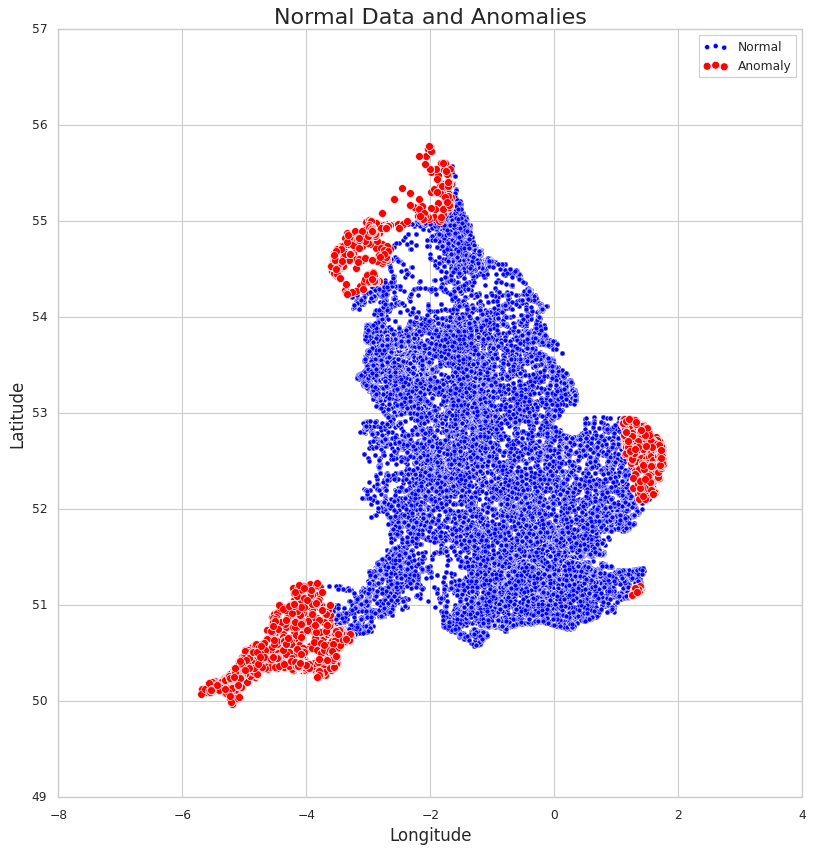

In [ ]:
# Setting the style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(12, 12))

# scatter plot for the normal data
sns.scatterplot(x=df_numerical['longitude'], y=df_numerical['latitude'], color='blue', s=20, label='Normal')

# scatter plot for the anomalies
sns.scatterplot(x=detected_outliers['longitude'], y=detected_outliers['latitude'], color='red', s=50, label='Anomaly')

# legend
plt.legend()

# titles and labels
plt.title('Normal Data and Anomalies', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)

# Show the plot
plt.show()

#### 9. Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?<a id="task18a"></a>

In [ ]:
df['accident_severity'].value_counts()

accident_severity
3    156928
2     39472
1      3469
Name: count, dtype: int64

In [ ]:
df.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'date', 'day_of_week', 'time', 'local_authority_district',
       'local_authority_ons_district', 'local_authority_highway',
       'first_road_class', 'first_road_number', 'road_type', 'speed_limit',
       'junction_detail', 'junction_control', 'second_road_class',
       'second_road_number', 'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location', 'vehicle_index',
       'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_loc

In [ ]:
df['accident_result'] = df['accident_severity'].apply(lambda x: 'Fatal' if x == 1 else 'Non-Fatal')  #Let's create a feature that houses all fatal and non-fatal accidents

In [ ]:
# Splitting the data into features and target
features = df.drop(['accident_result', 'accident_severity'], axis=1)
target = df['accident_result']

In [ ]:
# Converting mixed data type columns to strings
features = features.apply(lambda col: col.astype(str) if col.dtype == 'object' else col)

In [ ]:
# Encoding categorical features
label_encoders = {}
for column in features.columns:
    if features[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        features[column] = label_encoders[column].fit_transform(features[column])

In [ ]:
# Encoding the target variable
label_encoder_target = LabelEncoder()
target = label_encoder_target.fit_transform(target)

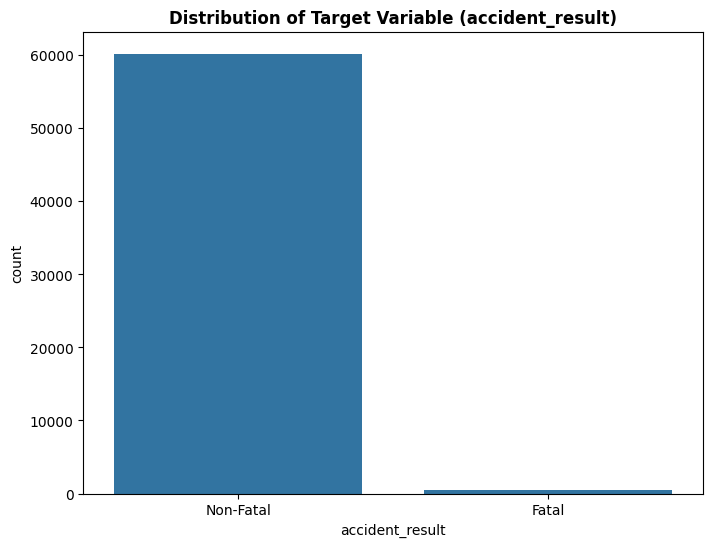

In [ ]:
# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='accident_result', data=df)
plt.title('Distribution of Target Variable (accident_result)', fontweight='bold')
plt.show()

The data is severely imbalanced, so let's try to sort that first using Random UnderSampler to reduce the number of observations in the majority class, which is Non-Fatal accidents in this case.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(features, target)

In [ ]:
y_resampled.shape

(956,)

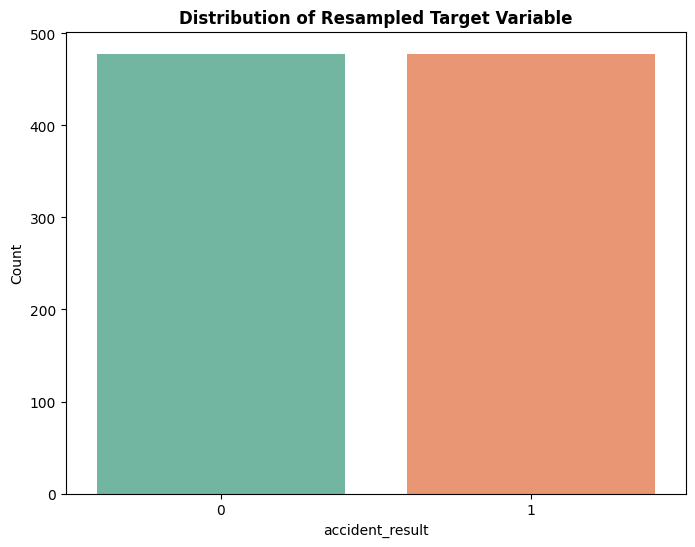

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='Set2')
plt.title('Distribution of Resampled Target Variable', fontweight='bold')
plt.xlabel('accident_result')
plt.ylabel('Count')
plt.show()

In [ ]:
X_resampled.shape

(956, 80)

Since Police Officers are sure to be at the site of every fatal accident, we will drop this feature.

In [ ]:
X_resampled.drop(columns = ['did_police_officer_attend_scene_of_accident'], inplace = True)

In [ ]:
X_resampled.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week',
       'time', 'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'trunk_road_flag', 'lsoa_of_accident_location',
       'vehicle_index', 'vehicle_type', 'towing_and_articulation',
       'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
   

In [ ]:
features = X_resampled
target = y_resampled

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
def get_ensemble_models():
    """
    Initialize ensemble models
    """
    models = {
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC()
    }
    return models

In [ ]:
def evaluate_model(model, X, y):
    """
    Evaluate a model using cross-validation
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=cv, error_score='raise')
    return scores

In [ ]:
# Getting the models
ensemble_models = get_ensemble_models()

ensemble_models

{'Random Forest': RandomForestClassifier(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 'Gradient Boosting': GradientBoostingClassifier(),
 'KNN': KNeighborsClassifier(),
 'SVM': SVC()}

In [ ]:
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)

In [ ]:
# Evaluating each model
model_scores = {}
for model_name, model in ensemble_models.items():
    scores = evaluate_model(model, X_train, y_train_numeric)
    model_scores[model_name] = scores
    print(f"{model_name}: Mean Accuracy = {scores.mean():.2f}, Std Dev = {scores.std():.3f}")

Random Forest: Mean Accuracy = 0.96, Std Dev = 0.030
XGBoost: Mean Accuracy = 0.96, Std Dev = 0.026
Gradient Boosting: Mean Accuracy = 0.95, Std Dev = 0.025
KNN: Mean Accuracy = 0.70, Std Dev = 0.061
SVM: Mean Accuracy = 0.51, Std Dev = 0.005


Let's explore how well a stacked model would perform

In [ ]:
def get_stacking():
    """
    Create a stacking classifier using specified base models.
    """
    # Initializing the base models
    level0 = [
        ('XGBoost', XGBClassifier()),
        ('Random Forest', RandomForestClassifier()),
        ('Gradient Boosting', GradientBoostingClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC())
    ]

    # Initializing the meta-model (final estimator)
    level1 = LogisticRegression()

    # Creating the stacking classifier
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
def get_ensemble_models():
    """
    Initialize ensemble models
    """
    models = {
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'Stacked Model': get_stacking()  # included the stacked model here
    }
    return models

In [ ]:
# Getting the models
stacked_models = get_ensemble_models()

stacked_models

{'Random Forest': RandomForestClassifier(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 'Gradient Boosting': GradientBoostingClassifier(),
 'KNN': KNeighborsClassifier(),
 'SVM': SVC(),
 'Stacked Model': StackingClassifier(cv=5,
                    estimators=[(

In [ ]:
# Evaluating the model
model_scores = {}
for model_name, model in stacked_models.items():
    scores = evaluate_model(model, X_train, y_train_numeric)
    model_scores[model_name] = scores
    print(f"{model_name}: Mean Accuracy = {scores.mean():.2f}, Std Dev = {scores.std():.3f}")

Random Forest: Mean Accuracy = 0.96, Std Dev = 0.022
XGBoost: Mean Accuracy = 0.96, Std Dev = 0.026
Gradient Boosting: Mean Accuracy = 0.95, Std Dev = 0.025
KNN: Mean Accuracy = 0.70, Std Dev = 0.061
SVM: Mean Accuracy = 0.51, Std Dev = 0.005
Stacked Model: Mean Accuracy = 0.96, Std Dev = 0.025


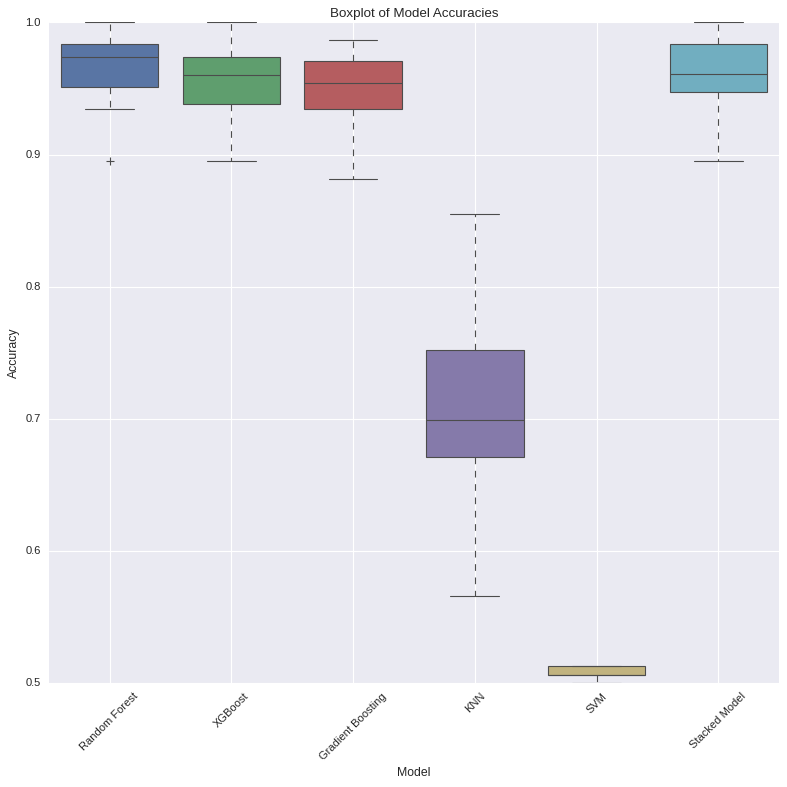

In [ ]:
# Converting model_scores dictionary to DataFrame
scores_df = pd.DataFrame.from_dict(model_scores)

plt.style.use('seaborn')

# Creating box plot using Seaborn
plt.figure(figsize=(10, 10))
sns.boxplot(data=scores_df)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Boxplot of Model Accuracies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()